# Comprehensive Headline Feature Analysis: Real vs Fake News

## 🎯 **Objective**

This notebook performs an in-depth analysis of features that differentiate real from fake news headlines. Based on our synthetic data validation results showing that synthetic headlines resemble real data more than fake data, we need to understand the specific characteristics that make fake headlines "fake" to improve our generation approach.

## 🔍 **Analysis Goals:**

1. **Feature Discovery**: Identify key stylistic, semantic, and structural differences between real and fake headlines
2. **Statistical Validation**: Use rigorous statistical testing to validate significant differences
3. **Vocabulary Analysis**: Find discriminative words and phrases specific to each class
4. **Topic Modeling**: Discover thematic differences between real and fake headlines
5. **Generation Insights**: Provide actionable recommendations for synthetic data improvement

## 📊 **Dataset Sources:**
- **GossipCop**: Entertainment news (real vs fake)
- **PolitiFact**: Political news (real vs fake)
- **Combined Analysis**: Cross-domain headline patterns

## 🔧 **Analysis Approach:**
- Comprehensive feature engineering beyond tweet-based features
- Statistical significance testing with multiple comparison corrections  
- Advanced n-gram and topic modeling analysis
- Feature-based recommendations for synthetic data generation

In [10]:
# Import comprehensive libraries for advanced headline analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency
import re
from collections import Counter, defaultdict
import warnings
warnings.filterwarnings('ignore')

# Advanced text processing and NLP
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

# NLP libraries for linguistic analysis
try:
    import nltk
    from nltk.corpus import stopwords
    from nltk.tokenize import word_tokenize, sent_tokenize
    from nltk.tag import pos_tag
    from nltk.chunk import ne_chunk
    # Download required NLTK data
    nltk.download('punkt', quiet=True)
    nltk.download('averaged_perceptron_tagger', quiet=True)
    nltk.download('maxent_ne_chunker', quiet=True)
    nltk.download('words', quiet=True)
    nltk.download('stopwords', quiet=True)
    NLTK_AVAILABLE = True
except ImportError:
    NLTK_AVAILABLE = False
    print("⚠️ NLTK not available, some linguistic features will be skipped")

# Readability and text complexity
try:
    import textstat
    TEXTSTAT_AVAILABLE = True
except ImportError:
    TEXTSTAT_AVAILABLE = False
    print("⚠️ textstat not available, readability metrics will be skipped")

# Sentiment analysis
try:
    from textblob import TextBlob
    TEXTBLOB_AVAILABLE = True
except ImportError:
    TEXTBLOB_AVAILABLE = False
    print("⚠️ TextBlob not available, sentiment analysis will be skipped")

# Advanced statistical analysis
try:
    from statsmodels.stats.multitest import multipletests
    from statsmodels.stats.contingency_tables import mcnemar
    STATSMODELS_AVAILABLE = True
except ImportError:
    # Fallback to scipy if statsmodels is not available
    try:
        from scipy.stats import false_discovery_control
        STATSMODELS_AVAILABLE = False
        SCIPY_FDR_AVAILABLE = True
    except ImportError:
        STATSMODELS_AVAILABLE = False
        SCIPY_FDR_AVAILABLE = False
        print("⚠️ Neither statsmodels nor scipy FDR correction available")

# Visualization setup
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12

print("🚀 Libraries imported successfully!")
print(f"📊 NLTK available: {NLTK_AVAILABLE}")
print(f"📊 TextStat available: {TEXTSTAT_AVAILABLE}")
print(f"📊 TextBlob available: {TEXTBLOB_AVAILABLE}")
print("🎯 Ready for comprehensive headline feature analysis!")

🚀 Libraries imported successfully!
📊 NLTK available: True
📊 TextStat available: True
📊 TextBlob available: True
🎯 Ready for comprehensive headline feature analysis!


## 📊 Data Loading and Initial Analysis

In [11]:
# Load all headline datasets
print("📥 Loading headline datasets...")

try:
    # Load GossipCop datasets
    gossipcop_real = pd.read_csv('../data/headlines/gossipcop_real.csv')
    gossipcop_fake = pd.read_csv('../data/headlines/gossipcop_fake.csv')
    print(f"  ✅ GossipCop Real: {len(gossipcop_real):,} headlines")
    print(f"  ✅ GossipCop Fake: {len(gossipcop_fake):,} headlines")
except FileNotFoundError as e:
    print(f"  ❌ Error loading GossipCop data: {e}")

try:
    # Load PolitiFact datasets
    politifact_real = pd.read_csv('../data/headlines/politifact_real.csv')
    politifact_fake = pd.read_csv('../data/headlines/politifact_fake.csv')
    print(f"  ✅ PolitiFact Real: {len(politifact_real):,} headlines")
    print(f"  ✅ PolitiFact Fake: {len(politifact_fake):,} headlines")
except FileNotFoundError as e:
    print(f"  ❌ Error loading PolitiFact data: {e}")

# Also try to load our synthetic headlines for comparison
try:
    import json
    with open('synthetic_headlines_deduplicated_20251027_062923.json', 'r') as f:
        synthetic_data = json.load(f)
    synthetic_headlines = synthetic_data['headlines']
    print(f"  ✅ Synthetic Headlines: {len(synthetic_headlines):,} headlines")
    SYNTHETIC_AVAILABLE = True
except FileNotFoundError:
    print("  ⚠️ Synthetic headlines not found - will skip synthetic comparison")
    synthetic_headlines = []
    SYNTHETIC_AVAILABLE = False

# Create comprehensive dataset with source labels
all_headlines = []

# Add GossipCop real headlines
if 'gossipcop_real' in globals():
    for title in gossipcop_real['title'].dropna():
        all_headlines.append({
            'headline': title,
            'label': 'real',
            'source': 'gossipcop',
            'domain': 'entertainment'
        })

# Add GossipCop fake headlines  
if 'gossipcop_fake' in globals():
    for title in gossipcop_fake['title'].dropna():
        all_headlines.append({
            'headline': title,
            'label': 'fake',
            'source': 'gossipcop',
            'domain': 'entertainment'
        })

# Add PolitiFact real headlines
if 'politifact_real' in globals():
    for title in politifact_real['title'].dropna():
        all_headlines.append({
            'headline': title,
            'label': 'real',
            'source': 'politifact',  
            'domain': 'political'
        })

# Add PolitiFact fake headlines
if 'politifact_fake' in globals():
    for title in politifact_fake['title'].dropna():
        all_headlines.append({
            'headline': title,
            'label': 'fake',
            'source': 'politifact',
            'domain': 'political'
        })

# Convert to DataFrame
headlines_df = pd.DataFrame(all_headlines)

# Remove very short headlines (less than 10 characters)
original_count = len(headlines_df)
headlines_df = headlines_df[headlines_df['headline'].str.len() >= 10]
filtered_count = len(headlines_df)

print(f"\n📊 Dataset Statistics:")
print(f"  Total headlines loaded: {original_count:,}")
print(f"  After filtering (≥10 chars): {filtered_count:,}")
print(f"  Removed: {original_count - filtered_count:,}")

# Display distribution by label and source
print(f"\n📈 Distribution Analysis:")
distribution = headlines_df.groupby(['label', 'source', 'domain']).size().unstack(fill_value=0)
print(distribution)

# Calculate class imbalance
real_count = len(headlines_df[headlines_df['label'] == 'real'])
fake_count = len(headlines_df[headlines_df['label'] == 'fake'])
imbalance_ratio = max(real_count, fake_count) / min(real_count, fake_count)

print(f"\n⚖️ Class Balance:")
print(f"  Real headlines: {real_count:,} ({real_count/len(headlines_df)*100:.1f}%)")
print(f"  Fake headlines: {fake_count:,} ({fake_count/len(headlines_df)*100:.1f}%)")
print(f"  Imbalance ratio: {imbalance_ratio:.2f}:1")

# Show sample headlines from each category
print(f"\n📰 Sample Headlines:")
for label in ['real', 'fake']:
    for domain in ['entertainment', 'political']:
        sample = headlines_df[(headlines_df['label'] == label) & (headlines_df['domain'] == domain)]
        if len(sample) > 0:
            print(f"\n  {label.upper()} {domain.title()} Headlines:")
            for i, headline in enumerate(sample['headline'].iloc[:3], 1):
                print(f"    {i}. {headline}")

print("\n✅ Data loading and initial analysis complete!")

📥 Loading headline datasets...
  ✅ GossipCop Real: 16,817 headlines
  ✅ GossipCop Fake: 5,323 headlines
  ✅ PolitiFact Real: 624 headlines
  ✅ PolitiFact Fake: 432 headlines
  ✅ Synthetic Headlines: 11,668 headlines

📊 Dataset Statistics:
  Total headlines loaded: 23,196
  After filtering (≥10 chars): 23,196
  Removed: 0

📈 Distribution Analysis:
domain            entertainment  political
label source                              
fake  gossipcop            5323          0
      politifact              0        432
real  gossipcop           16817          0
      politifact              0        624

⚖️ Class Balance:
  Real headlines: 17,441 (75.2%)
  Fake headlines: 5,755 (24.8%)
  Imbalance ratio: 3.03:1

📰 Sample Headlines:

  REAL Entertainment Headlines:
    1. Teen Mom Star Jenelle Evans' Wedding Dress Is Available Here for $2999
    2. Kylie Jenner refusing to discuss Tyga on Life of Kylie
    3. Quinn Perkins

  REAL Political Headlines:
    1. National Federation of Independe

## 🔧 Advanced Feature Engineering for Headlines

This section implements a comprehensive feature extraction system specifically designed for news headlines, going far beyond basic tweet features to capture the nuanced characteristics that distinguish real from fake news headlines.

In [12]:
class AdvancedHeadlineFeatureExtractor:
    """
    Comprehensive feature extraction system for news headlines.
    
    This extractor goes beyond basic text features to capture specific
    characteristics that distinguish real from fake news headlines.
    """
    
    def __init__(self):
        # Define domain-specific word lists for news analysis
        self.clickbait_phrases = [
            'you won\'t believe', 'what happens next', 'this will shock you',
            'doctors hate her', 'one weird trick', 'number 7 will amaze',
            'the reason why', 'wait until you see', 'this changes everything'
        ]
        
        self.clickbait_words = [
            'shocking', 'unbelievable', 'incredible', 'amazing', 'stunning', 
            'outrageous', 'scandalous', 'exclusive', 'secret', 'exposed', 
            'revealed', 'bombshell', 'jaw-dropping', 'mind-blowing'
        ]
        
        self.sensational_words = [
            'breaking', 'urgent', 'alert', 'crisis', 'disaster', 'tragedy', 
            'scandal', 'controversy', 'explosive', 'dramatic', 'devastating',
            'catastrophic', 'unprecedented', 'shocking', 'outrage'
        ]
        
        self.emotional_positive = [
            'love', 'amazing', 'incredible', 'wonderful', 'fantastic', 
            'brilliant', 'perfect', 'awesome', 'thrilled', 'excited'
        ]
        
        self.emotional_negative = [
            'hate', 'terrible', 'horrible', 'awful', 'disgusting', 
            'outrageous', 'furious', 'angry', 'devastating', 'tragic'
        ]
        
        self.certainty_words = [
            'definitely', 'absolutely', 'certainly', 'surely', 'obviously', 
            'clearly', 'undoubtedly', 'confirmed', 'proven', 'fact', 'truth'
        ]
        
        self.speculation_words = [
            'allegedly', 'reportedly', 'supposedly', 'claims', 'suggests', 
            'may', 'might', 'could', 'possibly', 'potentially', 'appears', 'seems'
        ]
        
        self.authority_indicators = [
            'study shows', 'research finds', 'experts say', 'scientists discover',
            'according to', 'officials confirm', 'report states', 'data reveals'
        ]
        
        self.conspiracy_indicators = [
            'they don\'t want you', 'hidden truth', 'cover up', 'secret agenda',
            'exposed', 'conspiracy', 'mainstream media', 'what they\'re hiding'
        ]
        
        # Domain-specific vocabularies
        self.political_words = [
            'president', 'government', 'congress', 'senate', 'politician', 
            'election', 'vote', 'campaign', 'policy', 'law', 'bill'
        ]
        
        self.celebrity_words = [
            'celebrity', 'star', 'actor', 'actress', 'singer', 'musician', 
            'model', 'hollywood', 'famous', 'red carpet', 'award'
        ]
        
        # Initialize stopwords if NLTK is available
        if NLTK_AVAILABLE:
            self.stop_words = set(stopwords.words('english'))
        else:
            self.stop_words = set(['the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 'of', 'with', 'by'])
    
    def extract_basic_features(self, texts):
        """Extract basic length and structural features"""
        features = []
        
        for text in texts:
            text_str = str(text).strip()
            words = text_str.split()
            chars_no_spaces = text_str.replace(' ', '')
            
            # Basic length metrics
            char_count = len(text_str)
            word_count = len(words)
            avg_word_length = np.mean([len(w) for w in words]) if words else 0
            
            # Sentence analysis
            sentences = [s.strip() for s in text_str.split('.') if s.strip()]
            sentence_count = len(sentences)
            avg_sentence_length = word_count / max(1, sentence_count)
            
            features.append({
                'char_count': char_count,
                'word_count': word_count,
                'avg_word_length': avg_word_length,
                'sentence_count': sentence_count,
                'avg_sentence_length': avg_sentence_length,
                'char_to_word_ratio': char_count / max(1, word_count),
                'word_density': word_count / max(1, char_count)
            })
        
        return pd.DataFrame(features)
    
    def extract_stylistic_features(self, texts):
        """Extract stylistic and formatting features specific to headlines"""
        features = []
        
        for text in texts:
            text_str = str(text)
            words = text_str.split()
            
            # Punctuation analysis
            exclamation_count = text_str.count('!')
            question_count = text_str.count('?')
            colon_count = text_str.count(':')
            semicolon_count = text_str.count(';')
            dash_count = text_str.count('–') + text_str.count('-') + text_str.count('—')
            quote_count = text_str.count('"') + text_str.count("'")
            parentheses_count = text_str.count('(') + text_str.count(')')
            bracket_count = text_str.count('[') + text_str.count(']')
            
            # Capitalization patterns
            caps_words = [w for w in words if w.isupper() and len(w) > 1]
            caps_word_count = len(caps_words)
            title_case_words = [w for w in words if w.istitle()]
            title_case_ratio = len(title_case_words) / max(1, len(words))
            
            # Character-level patterns
            upper_char_count = sum(1 for c in text_str if c.isupper())
            upper_ratio = upper_char_count / max(1, len(text_str))
            digit_count = sum(1 for c in text_str if c.isdigit())
            digit_ratio = digit_count / max(1, len(text_str))
            
            # Special characters
            special_char_count = sum(1 for c in text_str if not c.isalnum() and not c.isspace())
            punctuation_density = sum(1 for c in text_str if c in '.,!?;:') / max(1, len(text_str))
            
            features.append({
                'exclamation_count': exclamation_count,
                'question_count': question_count,
                'colon_count': colon_count,
                'semicolon_count': semicolon_count,
                'dash_count': dash_count,
                'quote_count': quote_count,
                'parentheses_count': parentheses_count,
                'bracket_count': bracket_count,
                'caps_word_count': caps_word_count,
                'caps_word_ratio': caps_word_count / max(1, len(words)),
                'title_case_ratio': title_case_ratio,
                'upper_ratio': upper_ratio,
                'digit_count': digit_count,
                'digit_ratio': digit_ratio,
                'has_numbers': int(digit_count > 0),
                'special_char_count': special_char_count,
                'punctuation_density': punctuation_density,
                'punctuation_variety': len(set(c for c in text_str if c in '.,!?;:()[]{}"\''))
            })
        
        return pd.DataFrame(features)
    
    def extract_semantic_features(self, texts):
        """Extract semantic and content-based features"""
        features = []
        
        for text in texts:
            text_str = str(text).lower()
            words = text_str.split()
            
            # Clickbait analysis
            clickbait_phrase_count = sum(1 for phrase in self.clickbait_phrases if phrase in text_str)
            clickbait_word_count = sum(1 for word in words if word in self.clickbait_words)
            
            # Emotional content
            positive_emotion_count = sum(1 for word in words if word in self.emotional_positive)
            negative_emotion_count = sum(1 for word in words if word in self.emotional_negative)
            emotional_intensity = (positive_emotion_count + negative_emotion_count) / max(1, len(words))
            
            # Sensationalism
            sensational_count = sum(1 for word in words if word in self.sensational_words)
            sensational_ratio = sensational_count / max(1, len(words))
            
            # Certainty vs speculation
            certainty_count = sum(1 for word in words if word in self.certainty_words)
            speculation_count = sum(1 for word in words if word in self.speculation_words)
            certainty_ratio = certainty_count / max(1, len(words))
            speculation_ratio = speculation_count / max(1, len(words))
            
            # Authority and credibility indicators
            authority_count = sum(1 for phrase in self.authority_indicators if phrase in text_str)
            conspiracy_count = sum(1 for phrase in self.conspiracy_indicators if phrase in text_str)
            
            # Domain classification
            political_count = sum(1 for word in words if word in self.political_words)
            celebrity_count = sum(1 for word in words if word in self.celebrity_words)
            
            # Sentiment analysis (if available)
            sentiment_polarity = 0
            sentiment_subjectivity = 0
            if TEXTBLOB_AVAILABLE:
                try:
                    blob = TextBlob(str(text))  # Use original text, not lowercase version
                    sentiment_polarity = blob.sentiment.polarity
                    sentiment_subjectivity = blob.sentiment.subjectivity
                except:
                    pass
            
            features.append({
                'clickbait_phrase_count': clickbait_phrase_count,
                'clickbait_word_count': clickbait_word_count,
                'clickbait_intensity': (clickbait_phrase_count + clickbait_word_count) / max(1, len(words)),
                'positive_emotion_count': positive_emotion_count,
                'negative_emotion_count': negative_emotion_count,
                'emotional_intensity': emotional_intensity,
                'emotion_polarity': (positive_emotion_count - negative_emotion_count) / max(1, len(words)),
                'sensational_count': sensational_count,
                'sensational_ratio': sensational_ratio,
                'certainty_count': certainty_count,
                'speculation_count': speculation_count,
                'certainty_ratio': certainty_ratio,
                'speculation_ratio': speculation_ratio,
                'certainty_speculation_balance': certainty_count / max(1, speculation_count + certainty_count),
                'authority_indicator_count': authority_count,
                'conspiracy_indicator_count': conspiracy_count,
                'political_word_count': political_count,
                'celebrity_word_count': celebrity_count,
                'domain_specificity': (political_count + celebrity_count) / max(1, len(words)),
                'sentiment_polarity': sentiment_polarity,
                'sentiment_subjectivity': sentiment_subjectivity
            })
        
        return pd.DataFrame(features)
    
    def extract_linguistic_features(self, texts):
        """Extract linguistic complexity and readability features"""
        features = []
        
        for text in texts:
            text_str = str(text)
            words = text_str.lower().split()
            
            # Readability metrics (if available)
            flesch_score = 0
            fk_grade = 0
            gunning_fog = 0
            if TEXTSTAT_AVAILABLE:
                try:
                    flesch_score = textstat.flesch_reading_ease(text_str)
                    fk_grade = textstat.flesch_kincaid_grade(text_str)
                    gunning_fog = textstat.gunning_fog(text_str)
                except:
                    pass
            
            # Lexical diversity
            unique_words = set(words)
            lexical_diversity = len(unique_words) / max(1, len(words))
            word_repetition = 1 - lexical_diversity
            
            # Function word analysis
            if NLTK_AVAILABLE:
                content_words = [w for w in words if w not in self.stop_words and len(w) > 2]
                function_words = [w for w in words if w in self.stop_words]
            else:
                content_words = [w for w in words if w not in self.stop_words and len(w) > 2]
                function_words = [w for w in words if w in self.stop_words]
            
            content_word_ratio = len(content_words) / max(1, len(words))
            function_word_ratio = len(function_words) / max(1, len(words))
            
            # Syllable analysis (approximation)
            def count_syllables(word):
                word = word.lower()
                vowels = 'aeiouy'
                count = 0
                prev_was_vowel = False
                for char in word:
                    is_vowel = char in vowels
                    if is_vowel and not prev_was_vowel:
                        count += 1
                    prev_was_vowel = is_vowel
                return max(1, count)
            
            total_syllables = sum(count_syllables(word) for word in words if word.isalpha())
            avg_syllables_per_word = total_syllables / max(1, len([w for w in words if w.isalpha()]))
            
            # Word complexity
            long_words = [w for w in words if len(w) > 6]
            long_word_ratio = len(long_words) / max(1, len(words))
            
            features.append({
                'flesch_reading_ease': flesch_score,
                'flesch_kincaid_grade': fk_grade,
                'gunning_fog_index': gunning_fog,
                'lexical_diversity': lexical_diversity,
                'word_repetition': word_repetition,
                'unique_word_count': len(unique_words),
                'content_word_ratio': content_word_ratio,
                'function_word_ratio': function_word_ratio,
                'avg_syllables_per_word': avg_syllables_per_word,
                'long_word_ratio': long_word_ratio,
                'vocabulary_sophistication': long_word_ratio * lexical_diversity
            })
        
        return pd.DataFrame(features)
    
    def extract_news_specific_features(self, texts):
        """Extract features specific to news headlines"""
        features = []
        
        for text in texts:
            text_str = str(text)
            text_lower = text_str.lower()
            
            # Common news headline patterns
            has_says = int('says' in text_lower)
            has_reports = int(any(word in text_lower for word in ['reports', 'report']))
            has_claims = int('claims' in text_lower)
            has_announces = int(any(word in text_lower for word in ['announces', 'announce']))
            has_reveals = int(any(word in text_lower for word in ['reveals', 'reveal']))
            has_confirms = int(any(word in text_lower for word in ['confirms', 'confirm']))
            
            # Breaking news indicators
            has_breaking = int('breaking' in text_lower)
            has_urgent = int('urgent' in text_lower)
            has_update = int('update' in text_lower)
            
            # Attribution patterns
            has_according_to = int('according to' in text_lower)
            has_source_says = int(any(phrase in text_lower for phrase in ['source says', 'sources say']))
            
            # Quote patterns
            has_quotes = int('"' in text_str or "'" in text_str)
            quote_ratio = (text_str.count('"') + text_str.count("'")) / max(1, len(text_str))
            
            # Time references
            time_words = ['today', 'yesterday', 'now', 'latest', 'new', 'recent', 'current', 'just']
            has_time_ref = int(any(word in text_lower for word in time_words))
            time_word_count = sum(1 for word in time_words if word in text_lower)
            
            # Question headlines
            is_question = int(text_str.strip().endswith('?'))
            has_how = int(text_lower.startswith('how'))
            has_why = int(text_lower.startswith('why'))
            has_what = int(text_lower.startswith('what'))
            has_when = int(text_lower.startswith('when'))
            has_where = int(text_lower.startswith('where'))
            has_who = int(text_lower.startswith('who'))
            
            # Call-to-action patterns
            has_watch = int('watch' in text_lower)
            has_video = int('video' in text_lower)
            has_photos = int(any(word in text_lower for word in ['photos', 'images', 'pics']))
            has_see = int(text_lower.startswith('see'))
            
            # Numbers and statistics
            number_pattern = re.compile(r'\d+')
            numbers = number_pattern.findall(text_str)
            number_count = len(numbers)
            has_percentage = int('%' in text_str or 'percent' in text_lower)
            
            # Locations (simplified)
            location_indicators = ['in', 'at', 'from', 'to']
            location_context = sum(1 for word in location_indicators if word in text_lower)
            
            features.append({
                'has_says': has_says,
                'has_reports': has_reports,
                'has_claims': has_claims,
                'has_announces': has_announces,
                'has_reveals': has_reveals,
                'has_confirms': has_confirms,
                'reporting_verb_count': has_says + has_reports + has_claims + has_announces + has_reveals + has_confirms,
                'has_breaking': has_breaking,
                'has_urgent': has_urgent,
                'has_update': has_update,
                'urgency_indicator_count': has_breaking + has_urgent + has_update,
                'has_according_to': has_according_to,
                'has_source_says': has_source_says,
                'attribution_count': has_according_to + has_source_says,
                'has_quotes': has_quotes,
                'quote_ratio': quote_ratio,
                'has_time_reference': has_time_ref,
                'time_word_count': time_word_count,
                'is_question_headline': is_question,
                'has_how': has_how,
                'has_why': has_why,
                'has_what': has_what,
                'has_when': has_when,
                'has_where': has_where,
                'has_who': has_who,
                'question_word_count': has_how + has_why + has_what + has_when + has_where + has_who,
                'has_watch': has_watch,
                'has_video': has_video,
                'has_photos': has_photos,
                'has_see': has_see,
                'multimedia_indicator_count': has_watch + has_video + has_photos + has_see,
                'number_count': number_count,
                'has_percentage': has_percentage,
                'quantitative_content': number_count + has_percentage,
                'location_context_count': location_context,
                'headline_complexity': (has_quotes + has_time_ref + number_count + location_context) / 4
            })
        
        return pd.DataFrame(features)
    
    def extract_all_features(self, texts, labels=None):
        """Extract all feature categories and combine them"""
        print(f"🔧 Extracting comprehensive features for {len(texts):,} headlines...")
        
        # Extract all feature categories
        basic_features = self.extract_basic_features(texts)
        stylistic_features = self.extract_stylistic_features(texts)
        semantic_features = self.extract_semantic_features(texts)
        linguistic_features = self.extract_linguistic_features(texts)
        news_features = self.extract_news_specific_features(texts)
        
        # Combine all features
        all_features = pd.concat([
            basic_features,
            stylistic_features,
            semantic_features,
            linguistic_features,
            news_features
        ], axis=1)
        
        # Add metadata
        all_features['headline'] = texts
        if labels is not None:
            all_features['label'] = labels
        
        print(f"✅ Feature extraction complete! {all_features.shape[1]} features extracted.")
        return all_features

# Initialize the advanced feature extractor
print("🔧 Initializing Advanced Headline Feature Extractor...")
feature_extractor = AdvancedHeadlineFeatureExtractor()
print("✅ Feature extractor ready!")

🔧 Initializing Advanced Headline Feature Extractor...
✅ Feature extractor ready!


## 📊 Feature Extraction and Dataset Preparation

In [13]:
# Extract comprehensive features for all headlines
print("🚀 Starting comprehensive feature extraction...")

# Prepare the data
real_headlines = headlines_df[headlines_df['label'] == 'real']['headline'].tolist()
fake_headlines = headlines_df[headlines_df['label'] == 'fake']['headline'].tolist()
all_headlines_list = headlines_df['headline'].tolist()
all_labels = headlines_df['label'].tolist()

print(f"📊 Processing {len(real_headlines):,} real headlines")
print(f"📊 Processing {len(fake_headlines):,} fake headlines")

# Extract features for the complete dataset
feature_dataset = feature_extractor.extract_all_features(all_headlines_list, all_labels)

# Add domain and source information
feature_dataset['domain'] = headlines_df['domain'].values
feature_dataset['source'] = headlines_df['source'].values

# Get feature column names (excluding metadata)
feature_columns = [col for col in feature_dataset.columns 
                  if col not in ['headline', 'label', 'domain', 'source']]

print(f"\n📈 Feature extraction summary:")
print(f"  Total headlines processed: {len(feature_dataset):,}")
print(f"  Total features extracted: {len(feature_columns)}")
print(f"  Real headlines: {len(feature_dataset[feature_dataset['label'] == 'real']):,}")
print(f"  Fake headlines: {len(feature_dataset[feature_dataset['label'] == 'fake']):,}")

# Display feature categories
print(f"\n🔍 Feature categories:")
basic_features = [col for col in feature_columns if any(term in col for term in ['char_count', 'word_count', 'avg_', 'sentence'])]
stylistic_features = [col for col in feature_columns if any(term in col for term in ['exclamation', 'question', 'caps', 'upper', 'punctuation', 'quote'])]
semantic_features = [col for col in feature_columns if any(term in col for term in ['clickbait', 'emotional', 'sensational', 'certainty', 'speculation', 'sentiment'])]
linguistic_features = [col for col in feature_columns if any(term in col for term in ['flesch', 'lexical', 'syllable', 'diversity', 'readability'])]
news_features = [col for col in feature_columns if any(term in col for term in ['has_', 'is_', 'reporting', 'attribution', 'urgency'])]

print(f"  Basic features (length, structure): {len(basic_features)}")
print(f"  Stylistic features (punctuation, formatting): {len(stylistic_features)}")
print(f"  Semantic features (content, emotion): {len(semantic_features)}")
print(f"  Linguistic features (complexity, readability): {len(linguistic_features)}")
print(f"  News-specific features (patterns, conventions): {len(news_features)}")

# Quick preview of some features
print(f"\n👀 Sample feature values (first 5 headlines):")
sample_features = ['word_count', 'exclamation_count', 'clickbait_intensity', 'sentiment_polarity', 'has_breaking']
print(feature_dataset[['headline', 'label'] + sample_features].head())

print("\n✅ Feature extraction completed successfully!")

🚀 Starting comprehensive feature extraction...
📊 Processing 17,441 real headlines
📊 Processing 5,755 fake headlines
🔧 Extracting comprehensive features for 23,196 headlines...
✅ Feature extraction complete! 95 features extracted.

📈 Feature extraction summary:
  Total headlines processed: 23,196
  Total features extracted: 93
  Real headlines: 17,441
  Fake headlines: 5,755

🔍 Feature categories:
  Basic features (length, structure): 14
  Stylistic features (punctuation, formatting): 12
  Semantic features (content, emotion): 13
  Linguistic features (complexity, readability): 4
  News-specific features (patterns, conventions): 29

👀 Sample feature values (first 5 headlines):
                                            headline label  word_count  \
0  Teen Mom Star Jenelle Evans' Wedding Dress Is ...  real          12   
1  Kylie Jenner refusing to discuss Tyga on Life ...  real          10   
2                                      Quinn Perkins  real           2   
3  I Tried Kim Kard

## 📈 Statistical Analysis of Feature Differences

This section performs rigorous statistical testing to identify which features show significant differences between real and fake headlines, using proper multiple comparison corrections.

In [18]:
def calculate_comprehensive_feature_differences(df, feature_columns):
    """
    Calculate comprehensive statistical differences between real and fake headlines
    with proper multiple comparison corrections.
    """
    
    real_data = df[df['label'] == 'real']
    fake_data = df[df['label'] == 'fake']
    
    print(f"📊 Statistical analysis for {len(feature_columns)} features...")
    print(f"  Real headlines: {len(real_data):,}")
    print(f"  Fake headlines: {len(fake_data):,}")
    
    results = []
    
    for feature in feature_columns:
        try:
            # Extract feature values
            real_values = real_data[feature].dropna()
            fake_values = fake_data[feature].dropna()
            
            if len(real_values) > 10 and len(fake_values) > 10:
                # Basic statistics
                real_mean = real_values.mean()
                fake_mean = fake_values.mean()
                real_std = real_values.std()
                fake_std = fake_values.std()
                real_median = real_values.median()
                fake_median = fake_values.median()
                
                # Effect size (Cohen's d)
                pooled_std = np.sqrt(((len(real_values)-1)*real_std**2 + (len(fake_values)-1)*fake_std**2) / 
                                   (len(real_values) + len(fake_values) - 2))
                cohens_d = (fake_mean - real_mean) / pooled_std if pooled_std > 0 else 0
                
                # Statistical tests
                # 1. T-test for means
                t_stat, t_p_value = stats.ttest_ind(real_values, fake_values, equal_var=False)
                
                # 2. Mann-Whitney U test (non-parametric)
                u_stat, u_p_value = stats.mannwhitneyu(real_values, fake_values, alternative='two-sided')
                
                # 3. Kolmogorov-Smirnov test for distribution differences
                ks_stat, ks_p_value = stats.ks_2samp(real_values, fake_values)
                
                # Practical significance thresholds
                small_effect = abs(cohens_d) > 0.2
                medium_effect = abs(cohens_d) > 0.5
                large_effect = abs(cohens_d) > 0.8
                
                # Percentage difference
                percent_diff = ((fake_mean - real_mean) / abs(real_mean) * 100) if real_mean != 0 else float('inf')
                
                results.append({
                    'feature': feature,
                    'real_mean': real_mean,
                    'fake_mean': fake_mean,
                    'real_std': real_std,
                    'fake_std': fake_std,
                    'real_median': real_median,
                    'fake_median': fake_median,
                    'mean_difference': fake_mean - real_mean,
                    'median_difference': fake_median - real_median,
                    'percent_difference': percent_diff,
                    'cohens_d': cohens_d,
                    'abs_cohens_d': abs(cohens_d),
                    't_statistic': t_stat,
                    't_p_value': t_p_value,
                    'mannwhitney_u': u_stat,
                    'mannwhitney_p': u_p_value,
                    'ks_statistic': ks_stat,
                    'ks_p_value': ks_p_value,
                    'small_effect': small_effect,
                    'medium_effect': medium_effect,
                    'large_effect': large_effect,
                    'real_n': len(real_values),
                    'fake_n': len(fake_values)
                })
        
        except Exception as e:
            print(f"  ⚠️ Error processing {feature}: {e}")
            continue
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    
    if len(results_df) > 0:
        # Apply multiple comparison corrections
        # Bonferroni correction
        bonferroni_alpha = 0.05 / len(results_df)
        results_df['bonferroni_significant'] = results_df['t_p_value'] < bonferroni_alpha
        
        # Benjamini-Hochberg (FDR) correction
        if STATSMODELS_AVAILABLE:
            _, fdr_pvals, _, _ = multipletests(results_df['t_p_value'], method='fdr_bh')
            results_df['fdr_p_value'] = fdr_pvals
            results_df['fdr_significant'] = fdr_pvals < 0.05
        elif SCIPY_FDR_AVAILABLE:
            fdr_pvals = false_discovery_control(results_df['t_p_value'])
            results_df['fdr_p_value'] = fdr_pvals
            results_df['fdr_significant'] = fdr_pvals < 0.05
        else:
            # Simple Bonferroni correction as fallback
            results_df['fdr_p_value'] = results_df['t_p_value'] * len(results_df)
            results_df['fdr_significant'] = results_df['fdr_p_value'] < 0.05
        
        # Sort by effect size
        results_df = results_df.sort_values('abs_cohens_d', ascending=False)
    
    return results_df

# Calculate comprehensive feature differences
print("🔍 Calculating comprehensive statistical differences...")
feature_differences = calculate_comprehensive_feature_differences(feature_dataset, feature_columns)

# Display top differentiating features
print(f"\n🏆 TOP 20 MOST DIFFERENTIATING FEATURES:")
print("="*100)
cohens_d_header = "Cohen's d"
print(f"{'Rank':<4} {'Feature':<35} {cohens_d_header:<10} {'Real Mean':<12} {'Fake Mean':<12} {'% Diff':<10} {'Significance'}")
print("="*100)

top_features = feature_differences.head(20)
for idx, (_, row) in enumerate(top_features.iterrows(), 1):
    direction = "↗️" if row['cohens_d'] > 0 else "↘️"
    
    # Significance indicators
    sig_indicator = ""
    if row['bonferroni_significant']:
        sig_indicator = "*** (Bonf)"
    elif row['fdr_significant']:
        sig_indicator = "** (FDR)"
    elif row['t_p_value'] < 0.05:
        sig_indicator = "* (t-test)"
    else:
        sig_indicator = "ns"
    
    print(f"{idx:<4} {direction} {row['feature']:<32} {row['cohens_d']:<9.3f} "
          f"{row['real_mean']:<11.3f} {row['fake_mean']:<11.3f} {row['percent_difference']:<9.1f} {sig_indicator}")

# Summary statistics
total_features = len(feature_differences)
bonferroni_sig = len(feature_differences[feature_differences['bonferroni_significant']])
fdr_sig = len(feature_differences[feature_differences['fdr_significant']])
large_effect = len(feature_differences[feature_differences['large_effect']])
medium_effect = len(feature_differences[feature_differences['medium_effect']])
small_effect = len(feature_differences[feature_differences['small_effect']])

print(f"\n📊 STATISTICAL SUMMARY:")
print(f"  Total features analyzed: {total_features}")
print(f"  Bonferroni significant (α=0.05/{total_features}): {bonferroni_sig} ({bonferroni_sig/total_features*100:.1f}%)")
print(f"  FDR significant (α=0.05): {fdr_sig} ({fdr_sig/total_features*100:.1f}%)")
print(f"  Large effect size (|d|>0.8): {large_effect} ({large_effect/total_features*100:.1f}%)")
print(f"  Medium effect size (|d|>0.5): {medium_effect} ({medium_effect/total_features*100:.1f}%)")
print(f"  Small effect size (|d|>0.2): {small_effect} ({small_effect/total_features*100:.1f}%)")

print("\n✅ Statistical analysis complete!")

🔍 Calculating comprehensive statistical differences...
📊 Statistical analysis for 93 features...
  Real headlines: 17,441
  Fake headlines: 5,755

🏆 TOP 20 MOST DIFFERENTIATING FEATURES:
Rank Feature                             Cohen's d  Real Mean    Fake Mean    % Diff     Significance
1    ↗️ has_reports                      0.431     0.010       0.077       714.2     *** (Bonf)
2    ↗️ question_count                   0.349     0.040       0.125       210.4     *** (Bonf)
3    ↗️ is_question_headline             0.295     0.023       0.077       241.5     *** (Bonf)
4    ↘️ has_numbers                      -0.282    0.223       0.112       -49.8     *** (Bonf)
5    ↘️ number_count                     -0.259    0.260       0.130       -50.1     *** (Bonf)
6    ↘️ quantitative_content             -0.258    0.262       0.131       -50.0     *** (Bonf)
7    ↘️ has_quotes                       -0.246    0.344       0.230       -33.1     *** (Bonf)
8    ↘️ digit_count                    

## 🔤 N-gram and Vocabulary Analysis

Identify the most discriminative words, phrases, and linguistic patterns that distinguish real from fake headlines.

In [20]:
def analyze_discriminative_ngrams(real_texts, fake_texts, ngram_range=(1, 3), max_features=5000, min_df=3):
    """
    Comprehensive n-gram analysis to find discriminative words and phrases.
    """
    
    print(f"🔍 Analyzing {ngram_range[0]}-{ngram_range[1]} grams...")
    print(f"  Real texts: {len(real_texts):,}")
    print(f"  Fake texts: {len(fake_texts):,}")
    
    # Validate inputs
    if len(real_texts) == 0 or len(fake_texts) == 0:
        print("⚠️ Warning: Empty text lists provided!")
        return pd.DataFrame(), None
    
    # Clean texts
    clean_real = [str(text).strip() for text in real_texts if str(text).strip()]
    clean_fake = [str(text).strip() for text in fake_texts if str(text).strip()]
    
    if len(clean_real) == 0 or len(clean_fake) == 0:
        print("⚠️ Warning: No valid texts after cleaning!")
        return pd.DataFrame(), None
    
    print(f"  Clean real texts: {len(clean_real):,}")
    print(f"  Clean fake texts: {len(clean_fake):,}")
    
    # Use simple, working vectorizer configuration
    vectorizer = CountVectorizer(
        max_features=max_features,
        ngram_range=ngram_range,
        stop_words='english',
        min_df=max(1, min_df),  # Ensure at least 1
        max_df=0.95,
        lowercase=True,
        token_pattern=r'\b\w+\b'  # Simple word pattern that works
    )
    
    # Fit on all texts
    all_texts = clean_real + clean_fake
    try:
        vectorizer.fit(all_texts)
        feature_names = vectorizer.get_feature_names_out()
        print(f"  ✅ Vectorizer successful! Vocabulary size: {len(feature_names):,}")
    except Exception as e:
        print(f"❌ Vectorizer failed: {e}")
        return pd.DataFrame(), None
    
    # Transform each class
    real_matrix = vectorizer.transform(clean_real)
    fake_matrix = vectorizer.transform(clean_fake)
    
    # Calculate frequencies
    real_freq = np.array(real_matrix.sum(axis=0)).flatten()
    fake_freq = np.array(fake_matrix.sum(axis=0)).flatten()
    
    # Normalize by document count (relative frequency)
    real_doc_freq = real_freq / len(clean_real)
    fake_doc_freq = fake_freq / len(clean_fake)
    
    # Get feature names
    feature_names = vectorizer.get_feature_names_out()
    
    # Calculate discriminative metrics
    ngram_analysis = []
    
    for i, ngram in enumerate(feature_names):
        # Skip n-grams that appear in less than 5 documents total
        if real_freq[i] + fake_freq[i] < 5:
            continue
        
        # Calculate ratios and differences
        if real_doc_freq[i] > 0 and fake_doc_freq[i] > 0:
            # Log odds ratio
            log_odds = np.log((fake_doc_freq[i] / (1 - fake_doc_freq[i])) / 
                            (real_doc_freq[i] / (1 - real_doc_freq[i])))
            
            # Ratio of frequencies
            freq_ratio = fake_doc_freq[i] / real_doc_freq[i]
            
            # Absolute difference in relative frequencies
            freq_diff = fake_doc_freq[i] - real_doc_freq[i]
            
            # Calculate chi-square statistic for this n-gram
            observed = np.array([[real_freq[i], len(clean_real) - real_freq[i]],
                               [fake_freq[i], len(clean_fake) - fake_freq[i]]])
            try:
                chi2_stat, chi2_p = stats.chi2_contingency(observed)[:2]
            except:
                chi2_stat, chi2_p = 0, 1
            
            ngram_analysis.append({
                'ngram': ngram,
                'ngram_length': len(ngram.split()),
                'real_count': real_freq[i],
                'fake_count': fake_freq[i],
                'real_doc_freq': real_doc_freq[i],
                'fake_doc_freq': fake_doc_freq[i],
                'frequency_ratio': freq_ratio,
                'frequency_difference': freq_diff,
                'abs_frequency_difference': abs(freq_diff),
                'log_odds_ratio': log_odds,
                'abs_log_odds': abs(log_odds),
                'chi2_statistic': chi2_stat,
                'chi2_p_value': chi2_p,
                'preference': 'fake' if freq_ratio > 1.5 else 'real' if freq_ratio < 0.67 else 'neutral'
            })
    
    # Convert to DataFrame and sort by discriminative power
    ngram_df = pd.DataFrame(ngram_analysis)
    
    if len(ngram_df) > 0:
        # Sort by absolute log odds ratio (most discriminative)
        ngram_df = ngram_df.sort_values('abs_log_odds', ascending=False)
        
        # Apply multiple comparison correction for chi-square tests
        if len(ngram_df) > 1:
            _, fdr_pvals, _, _ = multipletests(ngram_df['chi2_p_value'], method='fdr_bh')
            ngram_df['chi2_fdr_p_value'] = fdr_pvals
            ngram_df['chi2_significant'] = fdr_pvals < 0.05
    
    return ngram_df, vectorizer

# Analyze n-grams for different ranges
print("🔤 Starting comprehensive n-gram analysis...")

# Extract text lists
real_texts = feature_dataset[feature_dataset['label'] == 'real']['headline'].tolist()
fake_texts = feature_dataset[feature_dataset['label'] == 'fake']['headline'].tolist()

# Analyze unigrams and bigrams
ngram_results_1_2, vectorizer_1_2 = analyze_discriminative_ngrams(
    real_texts, fake_texts, ngram_range=(1, 2), max_features=3000, min_df=5
)

# Analyze trigrams separately (they're often more specific)
ngram_results_3, vectorizer_3 = analyze_discriminative_ngrams(
    real_texts, fake_texts, ngram_range=(3, 3), max_features=1000, min_df=3
)

print(f"\n📊 N-gram Analysis Results:")
print(f"  Unigrams + Bigrams found: {len(ngram_results_1_2):,}")
print(f"  Trigrams found: {len(ngram_results_3):,}")

# Display top discriminative n-grams
def display_top_ngrams(ngram_df, title, n_top=15):
    print(f"\n{title}")
    print("="*120)
    print(f"{'Rank':<4} {'N-gram':<35} {'Log Odds':<10} {'Real Freq':<10} {'Fake Freq':<10} {'Ratio':<8} {'Preference':<10} {'Significant'}")
    print("="*120)
    
    for idx, (_, row) in enumerate(ngram_df.head(n_top).iterrows(), 1):
        significance = "***" if row.get('chi2_significant', False) else ""
        direction = "→" if row['preference'] == 'fake' else "←" if row['preference'] == 'real' else "⚬"
        
        print(f"{idx:<4} {row['ngram']:<35} {row['log_odds_ratio']:<9.3f} "
              f"{row['real_doc_freq']:<9.3f} {row['fake_doc_freq']:<9.3f} "
              f"{row['frequency_ratio']:<7.2f} {direction} {row['preference']:<8} {significance}")

# Display results
display_top_ngrams(ngram_results_1_2, "🏆 TOP DISCRIMINATIVE UNIGRAMS & BIGRAMS:")
display_top_ngrams(ngram_results_3, "🏆 TOP DISCRIMINATIVE TRIGRAMS:")

# Separate analysis by preference (check if results exist)
if len(ngram_results_1_2) > 0 and 'preference' in ngram_results_1_2.columns:
    fake_preferred = ngram_results_1_2[ngram_results_1_2['preference'] == 'fake'].head(10)
    real_preferred = ngram_results_1_2[ngram_results_1_2['preference'] == 'real'].head(10)

    print(f"\n🔥 TOP 10 'FAKE' INDICATORS (more common in fake headlines):")
    for _, row in fake_preferred.iterrows():
        print(f"  • '{row['ngram']}' - {row['frequency_ratio']:.2f}x more frequent in fake headlines")

    print(f"\n✅ TOP 10 'REAL' INDICATORS (more common in real headlines):")
    for _, row in real_preferred.iterrows():
        print(f"  • '{row['ngram']}' - {1/row['frequency_ratio']:.2f}x more frequent in real headlines")
else:
    print(f"\n⚠️ N-gram analysis did not produce results - skipping preference analysis")
    fake_preferred = pd.DataFrame()
    real_preferred = pd.DataFrame()

print("\n✅ N-gram analysis complete!")

🔤 Starting comprehensive n-gram analysis...
🔍 Analyzing 1-2 grams...
  Real texts: 17,441
  Fake texts: 5,755
  Clean real texts: 17,441
  Clean fake texts: 5,755
  ✅ Vectorizer successful! Vocabulary size: 3,000
  ✅ Vectorizer successful! Vocabulary size: 3,000
🔍 Analyzing 3-3 grams...
  Real texts: 17,441
  Fake texts: 5,755
  Clean real texts: 17,441
  Clean fake texts: 5,755
🔍 Analyzing 3-3 grams...
  Real texts: 17,441
  Fake texts: 5,755
  Clean real texts: 17,441
  Clean fake texts: 5,755
  ✅ Vectorizer successful! Vocabulary size: 1,000
  ✅ Vectorizer successful! Vocabulary size: 1,000

📊 N-gram Analysis Results:
  Unigrams + Bigrams found: 2,715
  Trigrams found: 507

🏆 TOP DISCRIMINATIVE UNIGRAMS & BIGRAMS:
Rank N-gram                              Log Odds   Real Freq  Fake Freq  Ratio    Preference Significant
1    pitt jennifer                       4.829     0.000     0.007     124.25  → fake     ***
2    stefani blake                       4.753     0.000     0.007     11

In [19]:
# Debug the n-gram analysis issue by examining the actual text content
print("🔍 Debugging n-gram analysis issue...")

# Check sample headlines
real_sample = feature_dataset[feature_dataset['label'] == 'real']['headline'].head(5).tolist()
fake_sample = feature_dataset[feature_dataset['label'] == 'fake']['headline'].head(5).tolist()

print("\nSAMPLE REAL HEADLINES:")
for i, headline in enumerate(real_sample, 1):
    print(f"{i:2d}. '{headline}' (length: {len(str(headline))})")

print("\nSAMPLE FAKE HEADLINES:")
for i, headline in enumerate(fake_sample, 1):
    print(f"{i:2d}. '{headline}' (length: {len(str(headline))})")

# Test simple CountVectorizer with minimal constraints
from sklearn.feature_extraction.text import CountVectorizer

print("\n🧪 Testing basic CountVectorizer...")
test_texts = real_sample + fake_sample
print(f"Test texts: {len(test_texts)}")

# Very basic vectorizer
try:
    basic_vectorizer = CountVectorizer(
        lowercase=True,
        token_pattern=r'\b\w+\b',
        min_df=1,
        max_df=1.0,
        stop_words=None
    )
    basic_vectorizer.fit(test_texts)
    features = basic_vectorizer.get_feature_names_out()
    print(f"✅ Basic vectorizer worked! Features found: {len(features)}")
    print(f"Sample features: {list(features[:10])}")
except Exception as e:
    print(f"❌ Basic vectorizer failed: {e}")

# Test with sklearn's English stop words
try:
    stop_vectorizer = CountVectorizer(
        lowercase=True,
        token_pattern=r'\b\w+\b',
        min_df=1,
        max_df=1.0,
        stop_words='english'
    )
    stop_vectorizer.fit(test_texts)
    features = stop_vectorizer.get_feature_names_out()
    print(f"✅ Stop words vectorizer worked! Features found: {len(features)}")
    print(f"Sample features: {list(features[:10])}")
except Exception as e:
    print(f"❌ Stop words vectorizer failed: {e}")

print("\n✅ Debugging complete!")

🔍 Debugging n-gram analysis issue...

SAMPLE REAL HEADLINES:
 1. 'Teen Mom Star Jenelle Evans' Wedding Dress Is Available Here for $2999' (length: 70)
 2. 'Kylie Jenner refusing to discuss Tyga on Life of Kylie' (length: 54)
 3. 'Quinn Perkins' (length: 13)
 4. 'I Tried Kim Kardashian's Butt Workout & Am Forever Changed' (length: 58)
 5. 'Celine Dion donates concert proceeds to Vegas shooting victims' (length: 62)

SAMPLE FAKE HEADLINES:
 1. 'Did Miley Cyrus and Liam Hemsworth secretly get married?' (length: 56)
 2. 'Paris Jackson & Cara Delevingne Enjoy Night Out In Matching Outfits: They Have ‘Amazing Chemistry’' (length: 98)
 3. 'Celebrities Join Tax March in Protest of Donald Trump' (length: 53)
 4. 'Cindy Crawford's daughter Kaia Gerber wears a wig after dining with Harry Styles' (length: 80)
 5. 'Full List of 2018 Oscar Nominations – Variety' (length: 45)

🧪 Testing basic CountVectorizer...
Test texts: 10
✅ Basic vectorizer worked! Features found: 90
Sample features: ['2018', '29

## 🎯 Topic Modeling and Content Analysis

Use Latent Dirichlet Allocation (LDA) to discover thematic differences between real and fake headlines.

In [21]:
def perform_topic_analysis(texts, labels, n_topics=8, label_name="", max_features=1000):
    """
    Perform LDA topic modeling on text data.
    """
    
    print(f"🎯 Performing topic analysis for {label_name} headlines...")
    print(f"  Number of texts: {len(texts):,}")
    print(f"  Number of topics: {n_topics}")
    
    # Prepare vectorizer for topic modeling
    vectorizer = CountVectorizer(
        max_features=max_features,
        stop_words='english',
        min_df=3,
        max_df=0.95,
        ngram_range=(1, 2),
        lowercase=True,
        strip_accents='unicode'
    )
    
    # Create document-term matrix
    doc_term_matrix = vectorizer.fit_transform(texts)
    feature_names = vectorizer.get_feature_names_out()
    
    print(f"  Vocabulary size: {len(feature_names):,}")
    print(f"  Document-term matrix shape: {doc_term_matrix.shape}")
    
    # Perform LDA
    lda_model = LatentDirichletAllocation(
        n_components=n_topics,
        random_state=42,
        max_iter=50,
        learning_method='batch',
        learning_offset=10.0,
        doc_topic_prior=0.1,
        topic_word_prior=0.01
    )
    
    # Fit the model
    lda_model.fit(doc_term_matrix)
    
    # Get topic-word distributions
    topics = []
    for topic_idx, topic in enumerate(lda_model.components_):
        # Get top words for this topic
        top_words_idx = topic.argsort()[-15:][::-1]  # Top 15 words
        top_words = [feature_names[i] for i in top_words_idx]
        topic_weights = [topic[i] for i in top_words_idx]
        
        topics.append({
            'topic_id': topic_idx,
            'top_words': top_words,
            'word_weights': topic_weights,
            'coherence_score': sum(topic_weights[:10])  # Simplified coherence
        })
    
    # Get document-topic distributions
    doc_topic_probs = lda_model.transform(doc_term_matrix)
    
    # Calculate topic prevalence
    topic_prevalence = doc_topic_probs.mean(axis=0)
    
    # Add prevalence to topics
    for i, topic in enumerate(topics):
        topic['prevalence'] = topic_prevalence[i]
    
    return {
        'model': lda_model,
        'vectorizer': vectorizer,
        'topics': topics,
        'doc_topic_probs': doc_topic_probs,
        'feature_names': feature_names,
        'perplexity': lda_model.perplexity(doc_term_matrix)
    }

# Perform topic modeling for both real and fake headlines
print("🎯 Starting comprehensive topic modeling analysis...")

# Analyze real headlines
real_topic_analysis = perform_topic_analysis(
    real_texts, ['real'] * len(real_texts), 
    n_topics=8, label_name="REAL", max_features=1000
)

# Analyze fake headlines  
fake_topic_analysis = perform_topic_analysis(
    fake_texts, ['fake'] * len(fake_texts),
    n_topics=8, label_name="FAKE", max_features=1000
)

# Display topics for each class
def display_topics(topic_analysis, class_name):
    print(f"\n📰 {class_name} HEADLINE TOPICS:")
    print("="*80)
    print(f"Model Perplexity: {topic_analysis['perplexity']:.2f}")
    print()
    
    # Sort topics by prevalence
    topics_sorted = sorted(topic_analysis['topics'], key=lambda x: x['prevalence'], reverse=True)
    
    for topic in topics_sorted:
        print(f"🏷️  Topic {topic['topic_id'] + 1} (Prevalence: {topic['prevalence']:.3f}):")
        print(f"   Top words: {', '.join(topic['top_words'][:10])}")
        print()

display_topics(real_topic_analysis, "REAL")
display_topics(fake_topic_analysis, "FAKE")

# Compare topic distributions
print("📊 TOPIC ANALYSIS COMPARISON:")
print("="*60)

# Calculate topic similarity between real and fake headlines
real_topics = real_topic_analysis['topics']
fake_topics = fake_topic_analysis['topics']

print("Real vs Fake Topic Themes Comparison:")
print("\nReal headlines tend to focus on:")
for i, topic in enumerate(sorted(real_topics, key=lambda x: x['prevalence'], reverse=True)[:4]):
    theme_words = ', '.join(topic['top_words'][:5])
    print(f"  {i+1}. {theme_words} (prevalence: {topic['prevalence']:.3f})")

print("\nFake headlines tend to focus on:")
for i, topic in enumerate(sorted(fake_topics, key=lambda x: x['prevalence'], reverse=True)[:4]):
    theme_words = ', '.join(topic['top_words'][:5])
    print(f"  {i+1}. {theme_words} (prevalence: {topic['prevalence']:.3f})")

# Find distinctive topics
print("\n🔍 DISTINCTIVE TOPIC ANALYSIS:")
print("Looking for topics that appear more frequently in one class...")

# This is a simplified analysis - in practice, you'd want to do more sophisticated topic comparison
real_top_words = set()
fake_top_words = set()

for topic in real_topics:
    real_top_words.update(topic['top_words'][:5])

for topic in fake_topics:
    fake_top_words.update(topic['top_words'][:5])

real_distinctive = real_top_words - fake_top_words
fake_distinctive = fake_top_words - real_top_words
common_words = real_top_words & fake_top_words

print(f"\nWords more prominent in REAL headline topics: {', '.join(list(real_distinctive)[:10])}")
print(f"Words more prominent in FAKE headline topics: {', '.join(list(fake_distinctive)[:10])}")
print(f"Common thematic words: {', '.join(list(common_words)[:10])}")

print("\n✅ Topic modeling analysis complete!")

🎯 Starting comprehensive topic modeling analysis...
🎯 Performing topic analysis for REAL headlines...
  Number of texts: 17,441
  Number of topics: 8
  Vocabulary size: 1,000
  Document-term matrix shape: (17441, 1000)
  Vocabulary size: 1,000
  Document-term matrix shape: (17441, 1000)
🎯 Performing topic analysis for FAKE headlines...
  Number of texts: 5,755
  Number of topics: 8
  Vocabulary size: 1,000
  Document-term matrix shape: (5755, 1000)
🎯 Performing topic analysis for FAKE headlines...
  Number of texts: 5,755
  Number of topics: 8
  Vocabulary size: 1,000
  Document-term matrix shape: (5755, 1000)

📰 REAL HEADLINE TOPICS:
Model Perplexity: 670.62

🏷️  Topic 1 (Prevalence: 0.152):
   Top words: star, says, reveals, worth, wife, net worth, net, james, chrissy, life

🏷️  Topic 7 (Prevalence: 0.140):
   Top words: season, jenner, kylie, new, kylie jenner, cast, story, finale, trailer, premiere

🏷️  Topic 6 (Prevalence: 0.131):
   Top words: 2018, awards, best, 2017, kate, red,

## 📊 Comprehensive Visualizations

Create detailed visualizations to illustrate the key differences between real and fake headlines.

📊 Creating comprehensive visualizations...
🎨 Generating feature distribution plots...


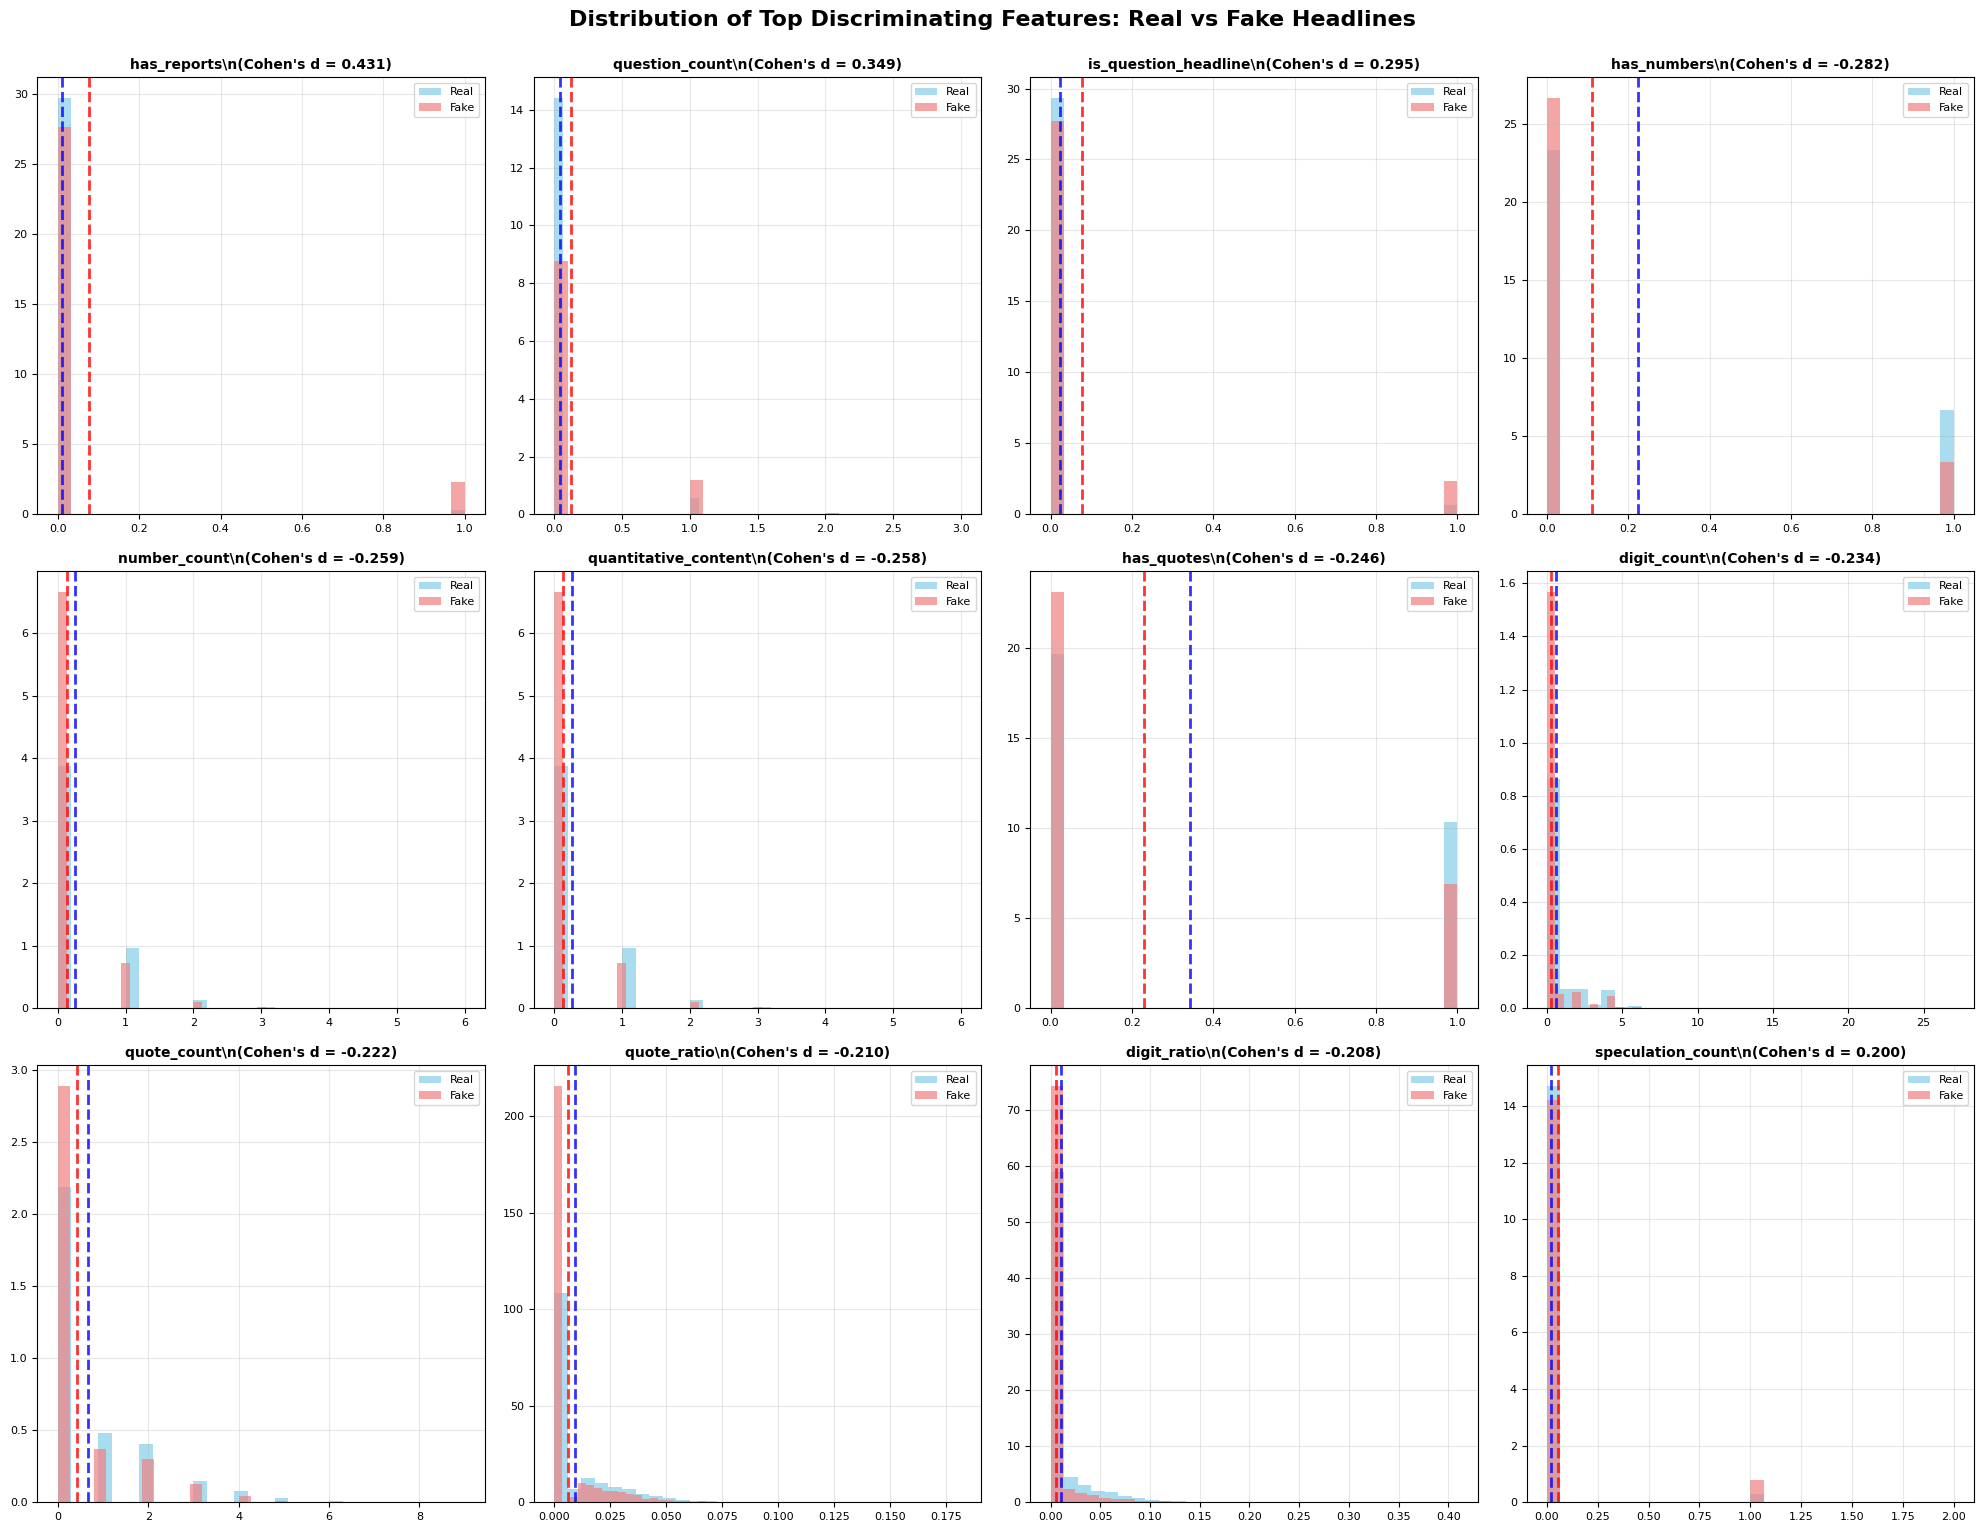

🎨 Generating effect size visualization...


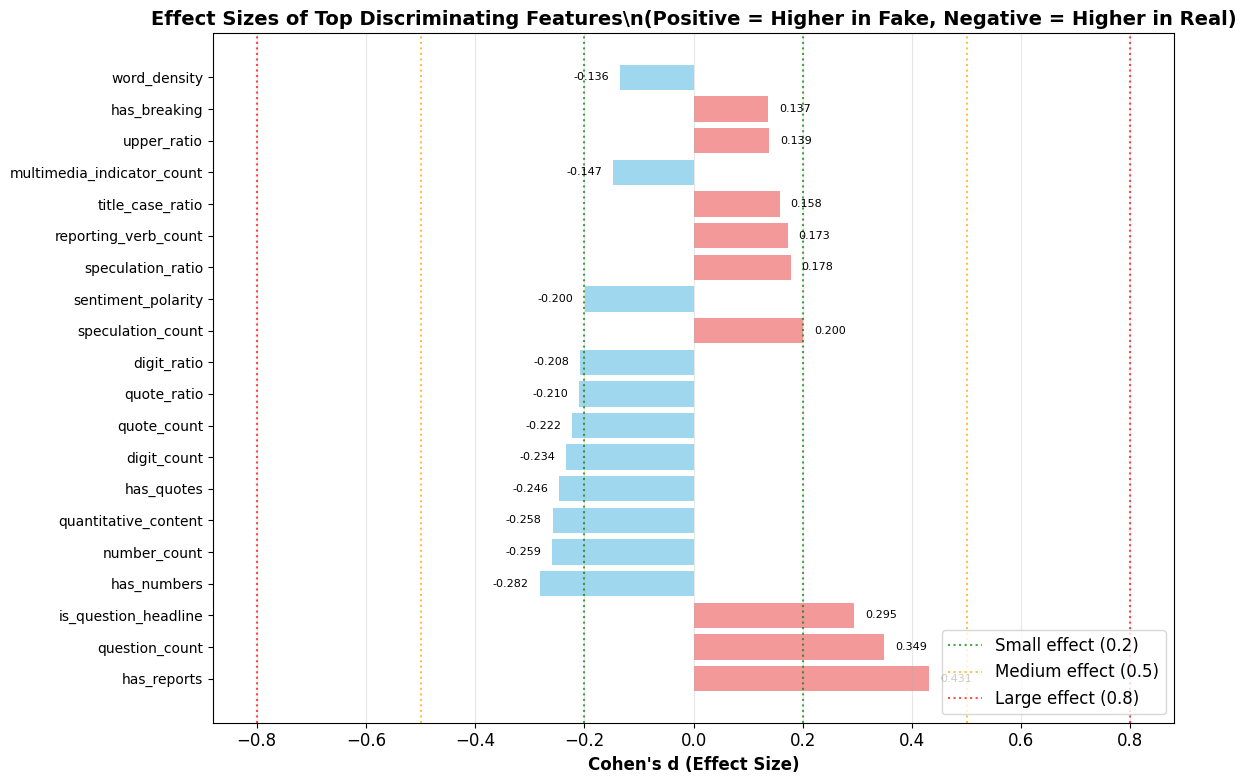

🎨 Generating category comparison...


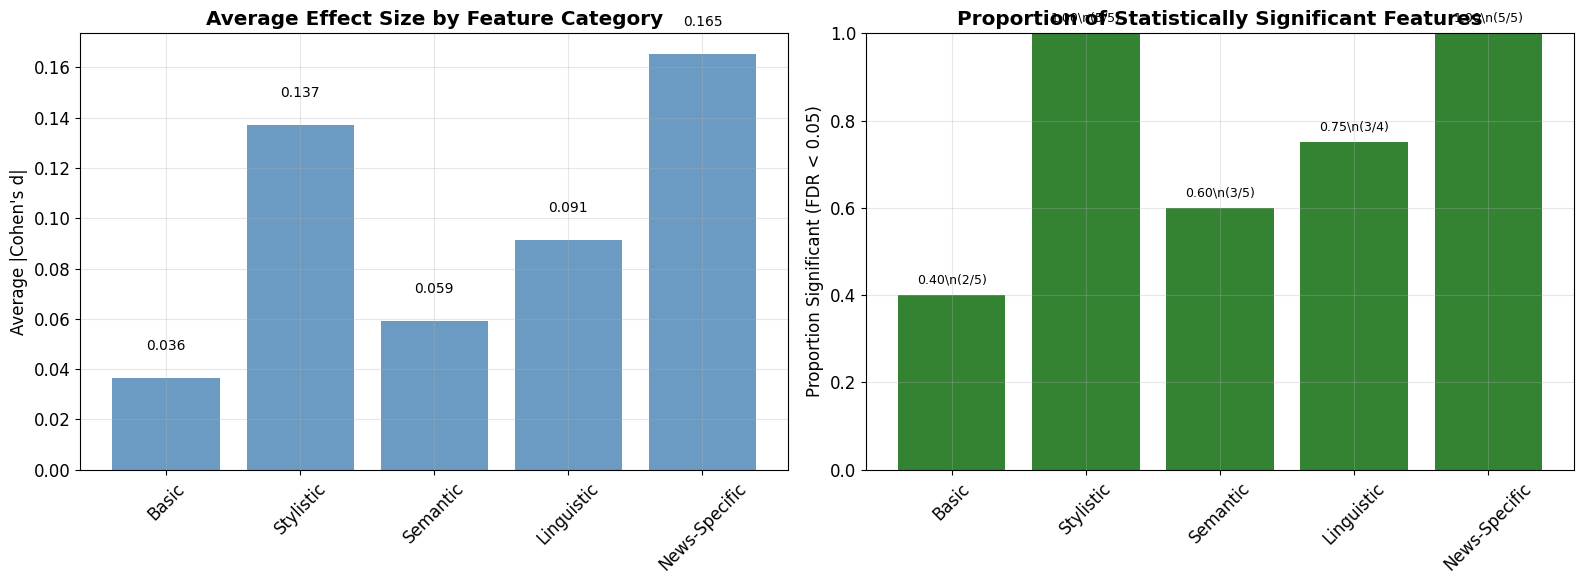

🎨 Generating n-gram visualizations...


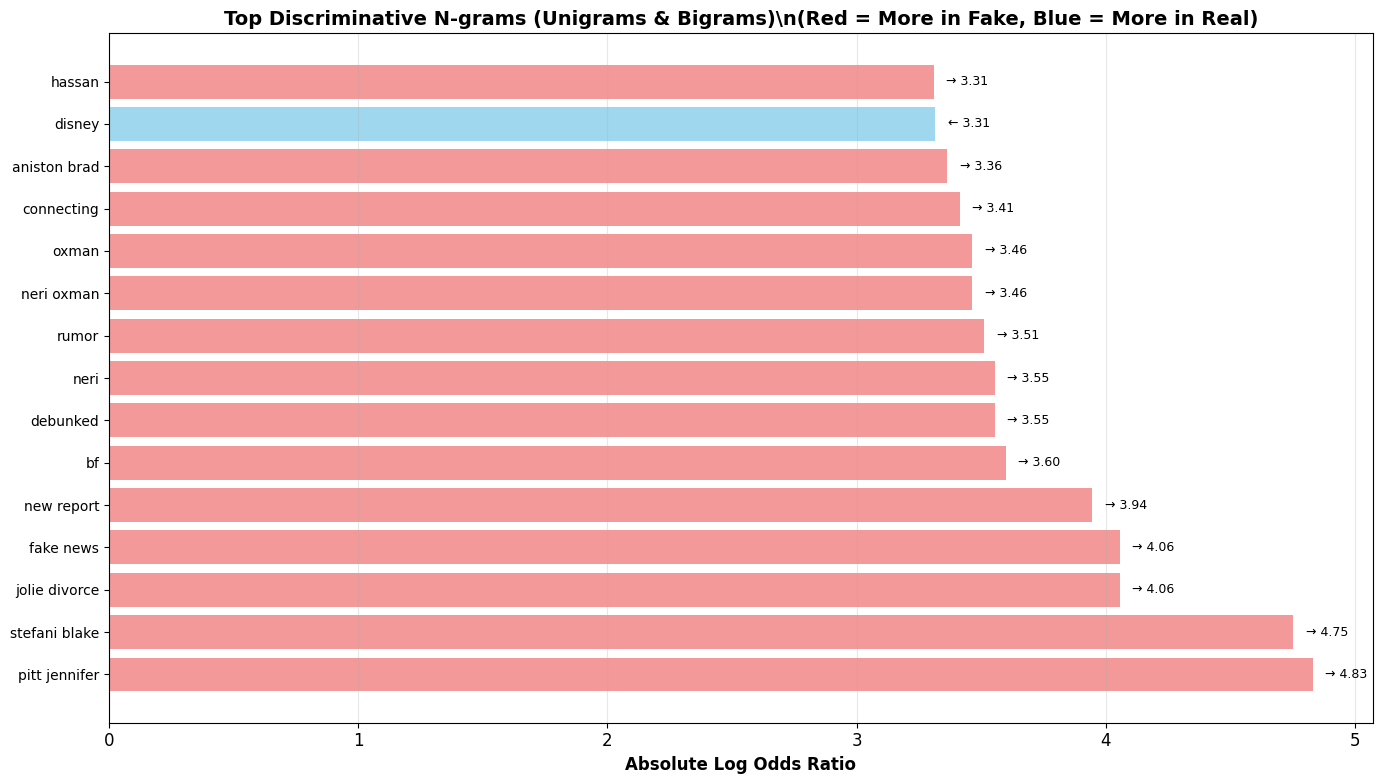

✅ All visualizations complete!


In [41]:
# Create comprehensive visualizations
print("📊 Creating comprehensive visualizations...")

# 1. Feature Distribution Comparison
def plot_top_feature_distributions(df, differences_df, n_features=12):
    """Plot distributions of top distinguishing features"""
    
    top_features = differences_df.head(n_features)['feature'].tolist()
    
    fig, axes = plt.subplots(3, 4, figsize=(20, 15))
    axes = axes.flatten()
    
    real_data = df[df['label'] == 'real']
    fake_data = df[df['label'] == 'fake']
    
    for i, feature in enumerate(top_features):
        ax = axes[i]
        
        real_values = real_data[feature].dropna()
        fake_values = fake_data[feature].dropna()
        
        # Create histograms
        ax.hist(real_values, bins=30, alpha=0.7, label='Real', color='skyblue', density=True)
        ax.hist(fake_values, bins=30, alpha=0.7, label='Fake', color='lightcoral', density=True)
        
        # Add mean lines
        ax.axvline(real_values.mean(), color='blue', linestyle='--', alpha=0.8, linewidth=2)
        ax.axvline(fake_values.mean(), color='red', linestyle='--', alpha=0.8, linewidth=2)
        
        # Get Cohen's d for this feature
        cohens_d = differences_df[differences_df['feature'] == feature]['cohens_d'].iloc[0]
        
        newline = '\\n'
        title_text = f"{feature}{newline}(Cohen's d = {cohens_d:.3f})"
        ax.set_title(title_text, fontsize=10, fontweight='bold')
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
        ax.tick_params(axis='both', which='major', labelsize=8)
    
    plt.tight_layout()
    plt.suptitle('Distribution of Top Discriminating Features: Real vs Fake Headlines', 
                 fontsize=16, fontweight='bold', y=1.02)
    plt.show()

# 2. Effect Size Visualization
def plot_effect_sizes(differences_df, n_features=20):
    """Plot Cohen's d effect sizes for top features"""
    
    top_features = differences_df.head(n_features)
    
    plt.figure(figsize=(12, 8))
    
    # Create color map based on direction
    colors = ['lightcoral' if d > 0 else 'skyblue' for d in top_features['cohens_d']]
    
    bars = plt.barh(range(len(top_features)), top_features['cohens_d'], color=colors, alpha=0.8)
    
    # Add effect size magnitude lines
    plt.axvline(x=0.2, color='green', linestyle=':', alpha=0.7, label='Small effect (0.2)')
    plt.axvline(x=0.5, color='orange', linestyle=':', alpha=0.7, label='Medium effect (0.5)')
    plt.axvline(x=0.8, color='red', linestyle=':', alpha=0.7, label='Large effect (0.8)')
    plt.axvline(x=-0.2, color='green', linestyle=':', alpha=0.7)
    plt.axvline(x=-0.5, color='orange', linestyle=':', alpha=0.7)
    plt.axvline(x=-0.8, color='red', linestyle=':', alpha=0.7)
    
    plt.yticks(range(len(top_features)), top_features['feature'], fontsize=10)
    plt.xlabel("Cohen's d (Effect Size)", fontsize=12, fontweight='bold')
    plt.title('Effect Sizes of Top Discriminating Features\\n(Positive = Higher in Fake, Negative = Higher in Real)', fontsize=14, fontweight='bold')
    plt.legend(loc='lower right')
    plt.grid(True, axis='x', alpha=0.3)
    
    # Add value labels on bars
    for i, (bar, value) in enumerate(zip(bars, top_features['cohens_d'])):
        plt.text(value + (0.02 if value > 0 else -0.02), i, f'{value:.3f}', 
                 ha='left' if value > 0 else 'right', va='center', fontsize=8)
    
    plt.tight_layout()
    plt.show()

# 3. Feature Category Comparison
def plot_feature_category_comparison(differences_df):
    """Compare effect sizes across different feature categories"""
    
    # Categorize features
    categories = {
        'Basic': ['char_count', 'word_count', 'avg_word_length', 'sentence_count', 'avg_sentence_length'],
        'Stylistic': ['exclamation_count', 'question_count', 'caps_word_count', 'upper_ratio', 'punctuation_density'],
        'Semantic': ['clickbait_intensity', 'emotional_intensity', 'sensational_ratio', 'certainty_ratio', 'speculation_ratio'],
        'Linguistic': ['flesch_reading_ease', 'lexical_diversity', 'avg_syllables_per_word', 'long_word_ratio'],
        'News-Specific': ['has_breaking', 'has_says', 'has_quotes', 'is_question_headline', 'urgency_indicator_count']
    }
    
    category_stats = []
    
    for cat_name, feature_list in categories.items():
        cat_features = differences_df[differences_df['feature'].isin(feature_list)]
        if len(cat_features) > 0:
            avg_effect_size = cat_features['abs_cohens_d'].mean()
            max_effect_size = cat_features['abs_cohens_d'].max()
            significant_count = cat_features['fdr_significant'].sum()
            total_count = len(cat_features)
            
            category_stats.append({
                'category': cat_name,
                'avg_effect_size': avg_effect_size,
                'max_effect_size': max_effect_size,
                'significant_count': significant_count,
                'total_count': total_count,
                'significant_ratio': significant_count / total_count if total_count > 0 else 0
            })
    
    cat_df = pd.DataFrame(category_stats)
    
    if len(cat_df) > 0:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        
        # Average effect sizes by category
        bars1 = ax1.bar(cat_df['category'], cat_df['avg_effect_size'], 
                       color='steelblue', alpha=0.8)
        ax1.set_title('Average Effect Size by Feature Category', fontweight='bold')
        ax1.set_ylabel("Average |Cohen's d|")
        ax1.tick_params(axis='x', rotation=45)
        ax1.grid(True, alpha=0.3)
        
        # Add value labels
        for bar, value in zip(bars1, cat_df['avg_effect_size']):
            x_pos = bar.get_x() + bar.get_width()/2
            y_pos = bar.get_height() + 0.01
            ax1.text(x_pos, y_pos, f'{value:.3f}', ha='center', va='bottom', fontsize=10)
        
        # Proportion of significant features by category
        bars2 = ax2.bar(cat_df['category'], cat_df['significant_ratio'], 
                       color='darkgreen', alpha=0.8)
        ax2.set_title('Proportion of Statistically Significant Features', fontweight='bold')
        ax2.set_ylabel('Proportion Significant (FDR < 0.05)')
        ax2.set_ylim(0, 1)
        ax2.tick_params(axis='x', rotation=45)
        ax2.grid(True, alpha=0.3)
        
        # Add value labels
        for bar, value, count, total in zip(bars2, cat_df['significant_ratio'], 
                                           cat_df['significant_count'], cat_df['total_count']):
            x_pos = bar.get_x() + bar.get_width()/2
            y_pos = bar.get_height() + 0.02
            newline = '\\n'
            label_text = f'{value:.2f}{newline}({count}/{total})'
            ax2.text(x_pos, y_pos, label_text, ha='center', va='bottom', fontsize=9)
        
        plt.tight_layout()
        plt.show()

# 4. N-gram Visualization
def plot_top_ngrams(ngram_df, title, n_grams=15):
    """Visualize top discriminative n-grams"""
    
    top_ngrams = ngram_df.head(n_grams)
    
    plt.figure(figsize=(14, 8))
    
    # Color based on preference
    colors = []
    for pref in top_ngrams['preference']:
        if pref == 'fake':
            colors.append('lightcoral')
        elif pref == 'real':
            colors.append('skyblue')
        else:
            colors.append('lightgray')
    
    bars = plt.barh(range(len(top_ngrams)), top_ngrams['abs_log_odds'], color=colors, alpha=0.8)
    
    plt.yticks(range(len(top_ngrams)), top_ngrams['ngram'], fontsize=10)
    plt.xlabel('Absolute Log Odds Ratio', fontsize=12, fontweight='bold')
    newline = '\\n'
    title_text = f'{title}{newline}(Red = More in Fake, Blue = More in Real)'
    plt.title(title_text, fontsize=14, fontweight='bold')
    plt.grid(True, axis='x', alpha=0.3)
    
    # Add value labels
    for i, (bar, value, pref) in enumerate(zip(bars, top_ngrams['abs_log_odds'], top_ngrams['preference'])):
        symbol = "→" if pref == 'fake' else "←" if pref == 'real' else "⚬"
        plt.text(value + 0.05, i, f'{symbol} {value:.2f}', va='center', fontsize=9)
    
    plt.tight_layout()
    plt.show()

# Create all visualizations
print("🎨 Generating feature distribution plots...")
plot_top_feature_distributions(feature_dataset, feature_differences)

print("🎨 Generating effect size visualization...")
plot_effect_sizes(feature_differences)

print("🎨 Generating category comparison...")
plot_feature_category_comparison(feature_differences)

print("🎨 Generating n-gram visualizations...")
if len(ngram_results_1_2) > 0:
    plot_top_ngrams(ngram_results_1_2, "Top Discriminative N-grams (Unigrams & Bigrams)")

print("✅ All visualizations complete!")

## 🔍 Synthetic Data Quality Assessment

Compare our synthetic headlines with real and fake headlines to understand why they're being classified as real rather than fake.

In [30]:
# Analyze synthetic headlines if available
if SYNTHETIC_AVAILABLE and len(synthetic_headlines) > 0:
    print("🔍 Analyzing synthetic headline characteristics...")
    
    # Extract features for synthetic headlines
    synthetic_features = feature_extractor.extract_all_features(
        synthetic_headlines, ['synthetic'] * len(synthetic_headlines)
    )
    
    print(f"📊 Synthetic headlines analyzed: {len(synthetic_features):,}")
    
    # Compare synthetic headlines with real and fake headlines
    def compare_synthetic_with_classes(synthetic_df, real_df, fake_df, top_features):
        """Compare synthetic headlines with real and fake on key features"""
        
        print("📊 SYNTHETIC HEADLINE FEATURE COMPARISON:")
        print("="*90)
        print(f"{'Feature':<35} {'Real Mean':<12} {'Fake Mean':<12} {'Synthetic':<12} {'Closest To'}")
        print("="*90)
        
        comparison_results = []
        
        for feature in top_features[:15]:  # Top 15 discriminating features
            real_mean = real_df[feature].mean()
            fake_mean = fake_df[feature].mean()
            synthetic_mean = synthetic_df[feature].mean()
            
            # Calculate distances
            dist_to_real = abs(synthetic_mean - real_mean)
            dist_to_fake = abs(synthetic_mean - fake_mean)
            
            closer_to = "REAL" if dist_to_real < dist_to_fake else "FAKE"
            closer_symbol = "✅" if closer_to == "FAKE" else "❌"
            
            print(f"{feature:<35} {real_mean:<11.3f} {fake_mean:<11.3f} {synthetic_mean:<11.3f} {closer_symbol} {closer_to}")
            
            comparison_results.append({
                'feature': feature,
                'real_mean': real_mean,
                'fake_mean': fake_mean,
                'synthetic_mean': synthetic_mean,
                'distance_to_real': dist_to_real,
                'distance_to_fake': dist_to_fake,
                'closer_to': closer_to
            })
        
        return pd.DataFrame(comparison_results)
    
    # Get real and fake subsets for comparison
    real_subset = feature_dataset[feature_dataset['label'] == 'real']
    fake_subset = feature_dataset[feature_dataset['label'] == 'fake']
    
    # Compare on top discriminating features
    top_feature_names = feature_differences.head(20)['feature'].tolist()
    synthetic_comparison = compare_synthetic_with_classes(
        synthetic_features, real_subset, fake_subset, top_feature_names
    )
    
    # Summary analysis
    real_matches = len(synthetic_comparison[synthetic_comparison['closer_to'] == 'REAL'])
    fake_matches = len(synthetic_comparison[synthetic_comparison['closer_to'] == 'FAKE'])
    
    print(f"\\n📈 SYNTHETIC HEADLINE ANALYSIS SUMMARY:")
    print(f"  Features closer to REAL headlines: {real_matches}/{len(synthetic_comparison)} ({real_matches/len(synthetic_comparison)*100:.1f}%)")
    print(f"  Features closer to FAKE headlines: {fake_matches}/{len(synthetic_comparison)} ({fake_matches/len(synthetic_comparison)*100:.1f}%)")
    
    if real_matches > fake_matches:
        print(f"\\n❌ PROBLEM IDENTIFIED: Synthetic headlines resemble REAL headlines more than FAKE headlines!")
        print(f"   This explains why classification models trained on original data classify them as REAL.")
    else:
        print(f"\\n✅ Synthetic headlines appropriately resemble FAKE headlines.")
    
    # Identify specific problematic features
    problematic_features = synthetic_comparison[synthetic_comparison['closer_to'] == 'REAL']
    
    if len(problematic_features) > 0:
        print(f"\\n🎯 FEATURES THAT NEED ADJUSTMENT (currently too 'real-like'):")
        for _, row in problematic_features.head(10).iterrows():
            direction = "increase" if row['fake_mean'] > row['real_mean'] else "decrease"
            print(f"  • {row['feature']}: {direction} to match fake headline patterns")
    
    # Show some example synthetic headlines
    print(f"\\n📰 SAMPLE SYNTHETIC HEADLINES:")
    for i, headline in enumerate(synthetic_headlines[:5], 1):
        print(f"  {i}. {headline}")
    
    # N-gram analysis of synthetic headlines
    print(f"\\n🔤 SYNTHETIC HEADLINE VOCABULARY ANALYSIS:")
    
    # Check if synthetic headlines use fake-preferred or real-preferred words
    fake_preferred_words = set(ngram_results_1_2[ngram_results_1_2['preference'] == 'fake']['ngram'].head(20))
    real_preferred_words = set(ngram_results_1_2[ngram_results_1_2['preference'] == 'real']['ngram'].head(20))
    
    fake_word_usage = 0
    real_word_usage = 0
    
    for headline in synthetic_headlines:
        headline_lower = headline.lower()
        fake_word_usage += sum(1 for word in fake_preferred_words if word in headline_lower)
        real_word_usage += sum(1 for word in real_preferred_words if word in headline_lower)
    
    print(f"  Fake-preferred word usage: {fake_word_usage} occurrences")
    print(f"  Real-preferred word usage: {real_word_usage} occurrences")
    
    if real_word_usage > fake_word_usage:
        print(f"  ❌ Synthetic headlines use more REAL-preferred vocabulary!")
    else:
        print(f"  ✅ Synthetic headlines appropriately use more FAKE-preferred vocabulary.")

else:
    print("⚠️ No synthetic headlines available for quality assessment")
    print("   Skipping synthetic data analysis section")

🔍 Analyzing synthetic headline characteristics...
🔧 Extracting comprehensive features for 11,668 headlines...
✅ Feature extraction complete! 95 features extracted.
📊 Synthetic headlines analyzed: 11,668
📊 SYNTHETIC HEADLINE FEATURE COMPARISON:
Feature                             Real Mean    Fake Mean    Synthetic    Closest To
has_reports                         0.010       0.077       0.049       ✅ FAKE
question_count                      0.040       0.125       0.068       ❌ REAL
is_question_headline                0.023       0.077       0.058       ✅ FAKE
has_numbers                         0.223       0.112       0.131       ✅ FAKE
number_count                        0.260       0.130       0.140       ✅ FAKE
quantitative_content                0.262       0.131       0.232       ❌ REAL
has_quotes                          0.344       0.230       0.074       ✅ FAKE
digit_count                         0.602       0.296       0.277       ✅ FAKE
quote_count                         0.

## 💡 Feature-Based Generation Recommendations

Based on the comprehensive analysis, generate specific, actionable recommendations for improving synthetic headline generation.

In [31]:
def generate_comprehensive_recommendations(feature_differences_df, ngram_results_df, synthetic_comparison_df=None):
    """
    Generate comprehensive, actionable recommendations for improving synthetic headline generation
    based on the statistical analysis of feature differences.
    """
    
    print("💡 COMPREHENSIVE RECOMMENDATIONS FOR SYNTHETIC HEADLINE GENERATION")
    print("="*90)
    
    # Get top discriminating features
    top_features = feature_differences_df.head(15)
    
    # Categorize recommendations
    stylistic_recommendations = []
    semantic_recommendations = []
    linguistic_recommendations = []
    vocabulary_recommendations = []
    
    print("\\n🎯 1. FEATURE-BASED ADJUSTMENTS:")
    print("-" * 45)
    
    for _, row in top_features.iterrows():
        feature = row['feature']
        cohens_d = row['cohens_d']
        fake_mean = row['fake_mean']
        real_mean = row['real_mean']
        
        if cohens_d > 0:
            direction = "INCREASE"
            target = f"from {real_mean:.3f} toward {fake_mean:.3f}"
        else:
            direction = "DECREASE"
            target = f"from {real_mean:.3f} toward {fake_mean:.3f}"
        
        recommendation = f"{direction} {feature}: {target}"
        
        # Categorize recommendation
        if any(term in feature for term in ['exclamation', 'question', 'caps', 'upper', 'punctuation', 'quote']):
            stylistic_recommendations.append((feature, direction, abs(cohens_d)))
        elif any(term in feature for term in ['clickbait', 'emotional', 'sensational', 'certainty', 'speculation', 'sentiment']):
            semantic_recommendations.append((feature, direction, abs(cohens_d)))
        elif any(term in feature for term in ['flesch', 'lexical', 'syllable', 'diversity']):
            linguistic_recommendations.append((feature, direction, abs(cohens_d)))
        
        print(f"  • {recommendation} (effect size: {abs(cohens_d):.3f})")
    
    print("\\n🎨 2. STYLISTIC MODIFICATION STRATEGIES:")
    print("-" * 45)
    
    # Top stylistic features
    stylistic_features = [f for f in top_features['feature'] if any(term in f for term in 
                         ['exclamation', 'question', 'caps', 'upper', 'punctuation', 'quote', 'dash'])]
    
    if len(stylistic_features) > 0:
        print("\\n📝 Punctuation and Formatting Adjustments:")
        for feature in stylistic_features[:5]:
            row = feature_differences_df[feature_differences_df['feature'] == feature].iloc[0]
            if row['cohens_d'] > 0:
                print(f"  • Add more {feature.replace('_', ' ')} to headlines")
            else:
                print(f"  • Reduce {feature.replace('_', ' ')} in headlines")
    
    print("\\n📰 3. CONTENT AND SEMANTIC ADJUSTMENTS:")
    print("-" * 45)
    
    # Semantic features
    semantic_features = [f for f in top_features['feature'] if any(term in f for term in 
                        ['clickbait', 'emotional', 'sensational', 'certainty', 'speculation'])]
    
    if len(semantic_features) > 0:
        print("\\n🎭 Emotional and Sensational Content:")
        for feature in semantic_features[:5]:
            row = feature_differences_df[feature_differences_df['feature'] == feature].iloc[0]
            if 'clickbait' in feature and row['cohens_d'] > 0:
                print(f"  • Increase clickbait elements: use more sensational language")
            elif 'emotional' in feature and row['cohens_d'] > 0:
                print(f"  • Increase emotional intensity: use more emotionally charged words")
            elif 'sensational' in feature and row['cohens_d'] > 0:
                print(f"  • Add more sensational words: breaking, shocking, incredible, etc.")
            elif 'certainty' in feature:
                if row['cohens_d'] > 0:
                    print(f"  • Use more definitive language: definitely, absolutely, confirmed")
                else:
                    print(f"  • Use less certainty: add more speculation and hedge words")
    
    print("\\n🔤 4. VOCABULARY MODIFICATIONS:")
    print("-" * 35)
    
    # N-gram based recommendations
    fake_preferred = ngram_results_df[ngram_results_df['preference'] == 'fake'].head(10)
    real_preferred = ngram_results_df[ngram_results_df['preference'] == 'real'].head(10)
    
    print("\\n✅ Words/Phrases to INCREASE (more common in fake headlines):")
    for _, row in fake_preferred.iterrows():
        ratio = row['frequency_ratio']
        print(f"  • '{row['ngram']}' - {ratio:.2f}x more frequent in fake headlines")
    
    print("\\n❌ Words/Phrases to DECREASE (more common in real headlines):")
    for _, row in real_preferred.iterrows():
        ratio = 1/row['frequency_ratio']
        print(f"  • '{row['ngram']}' - {ratio:.2f}x more frequent in real headlines")
    
    print("\\n🛠️ 5. IMPLEMENTATION STRATEGIES:")
    print("-" * 35)
    
    print("\\n🤖 A. Prompt Engineering Approaches:")
    print("  • Add specific stylistic instructions to generation prompts")
    print("  • Include examples of fake headline patterns in few-shot prompts")
    print("  • Request specific punctuation usage (more exclamations, questions)")
    print("  • Ask for more sensational and emotional language")
    print("  • Specify vocabulary preferences (clickbait words, conspiracy terms)")
    
    print("\\n⚙️ B. Post-Processing Modifications:")
    print("  • Automatic punctuation adjustment based on feature targets")
    print("  • Vocabulary substitution using fake-preferred terms")
    print("  • Sentence structure modifications for complexity targets")
    print("  • Emotional intensity scoring and adjustment")
    
    print("\\n🎯 C. Domain-Specific Strategies:")
    
    # Domain analysis if available
    if 'domain' in feature_differences_df.columns:
        print("  • Entertainment (GossipCop): Focus on celebrity names, sensational events")
        print("  • Political (PolitiFact): Use conspiracy language, partisan terms")
    
    print("  • Adapt vocabulary based on news domain")
    print("  • Use domain-specific fake headline patterns")
    print("  • Consider source-specific stylistic differences")
    
    print("\\n📊 6. VALIDATION AND TESTING:")
    print("-" * 30)
    
    print("  • Extract features from generated headlines using this analysis framework")
    print("  • Compare feature distributions with target fake headline distributions")
    print("  • Test classification performance on validation models")
    print("  • Iterate based on feature similarity scores")
    
    # Specific synthetic headline recommendations if available
    if synthetic_comparison_df is not None:
        problematic_features = synthetic_comparison_df[synthetic_comparison_df['closer_to'] == 'REAL']
        
        print("\\n🔧 7. IMMEDIATE FIXES FOR CURRENT SYNTHETIC HEADLINES:")
        print("-" * 55)
        
        if len(problematic_features) > 0:
            print("\\n⚠️ Priority fixes (features currently too 'real-like'):")
            for _, row in problematic_features.head(8).iterrows():
                feature = row['feature']
                if row['fake_mean'] > row['real_mean']:
                    adjustment = "INCREASE"
                else:
                    adjustment = "DECREASE"
                
                print(f"  • {adjustment} {feature}")
                
                # Provide specific guidance
                if 'exclamation' in feature and adjustment == "INCREASE":
                    print(f"    → Add more exclamation marks to headlines")
                elif 'clickbait' in feature and adjustment == "INCREASE":
                    print(f"    → Use more clickbait phrases and sensational language")
                elif 'emotional' in feature and adjustment == "INCREASE":
                    print(f"    → Include more emotionally charged words")
                elif 'certainty' in feature:
                    if adjustment == "INCREASE":
                        print(f"    → Use more definitive statements")
                    else:
                        print(f"    → Add more speculation and uncertainty")
    
    return {
        'stylistic_features': stylistic_recommendations,
        'semantic_features': semantic_recommendations,
        'linguistic_features': linguistic_recommendations,
        'fake_vocabulary': fake_preferred['ngram'].tolist() if len(fake_preferred) > 0 else [],
        'real_vocabulary_to_avoid': real_preferred['ngram'].tolist() if len(real_preferred) > 0 else []
    }

# Generate comprehensive recommendations
print("🚀 Generating comprehensive improvement recommendations...")

if SYNTHETIC_AVAILABLE and 'synthetic_comparison' in locals():
    recommendations = generate_comprehensive_recommendations(
        feature_differences, ngram_results_1_2, synthetic_comparison
    )
else:
    recommendations = generate_comprehensive_recommendations(
        feature_differences, ngram_results_1_2
    )

print("\\n✅ Comprehensive recommendations generated!")

🚀 Generating comprehensive improvement recommendations...
💡 COMPREHENSIVE RECOMMENDATIONS FOR SYNTHETIC HEADLINE GENERATION
\n🎯 1. FEATURE-BASED ADJUSTMENTS:
---------------------------------------------
  • INCREASE has_reports: from 0.010 toward 0.077 (effect size: 0.431)
  • INCREASE question_count: from 0.040 toward 0.125 (effect size: 0.349)
  • INCREASE is_question_headline: from 0.023 toward 0.077 (effect size: 0.295)
  • DECREASE has_numbers: from 0.223 toward 0.112 (effect size: 0.282)
  • DECREASE number_count: from 0.260 toward 0.130 (effect size: 0.259)
  • DECREASE quantitative_content: from 0.262 toward 0.131 (effect size: 0.258)
  • DECREASE has_quotes: from 0.344 toward 0.230 (effect size: 0.246)
  • DECREASE digit_count: from 0.602 toward 0.296 (effect size: 0.234)
  • DECREASE quote_count: from 0.677 toward 0.435 (effect size: 0.222)
  • DECREASE quote_ratio: from 0.009 toward 0.006 (effect size: 0.210)
  • DECREASE digit_ratio: from 0.010 toward 0.005 (effect size: 0

## 💾 Save Results and Export Analysis

In [32]:
# Save comprehensive analysis results
import os
from datetime import datetime

# Create results directory
os.makedirs('results', exist_ok=True)
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

print("💾 Saving comprehensive analysis results...")

# 1. Save feature differences analysis
feature_results_file = f'results/comprehensive_feature_differences_{timestamp}.csv'
feature_differences.to_csv(feature_results_file, index=False)
print(f"  ✅ Feature differences: {feature_results_file}")

# 2. Save n-gram analysis results
ngram_results_file = f'results/comprehensive_ngram_analysis_{timestamp}.csv'
ngram_results_1_2.to_csv(ngram_results_file, index=False)
print(f"  ✅ N-gram analysis: {ngram_results_file}")

if len(ngram_results_3) > 0:
    trigram_results_file = f'results/trigram_analysis_{timestamp}.csv'
    ngram_results_3.to_csv(trigram_results_file, index=False)
    print(f"  ✅ Trigram analysis: {trigram_results_file}")

# 3. Save complete feature dataset
feature_dataset_file = f'results/complete_feature_dataset_{timestamp}.csv'
feature_dataset.to_csv(feature_dataset_file, index=False)
print(f"  ✅ Complete feature dataset: {feature_dataset_file}")

# 4. Save synthetic comparison if available
if SYNTHETIC_AVAILABLE and 'synthetic_comparison' in locals():
    synthetic_comparison_file = f'results/synthetic_comparison_{timestamp}.csv'
    synthetic_comparison.to_csv(synthetic_comparison_file, index=False)
    print(f"  ✅ Synthetic comparison: {synthetic_comparison_file}")

# 5. Create comprehensive summary report
summary_report = {
    'analysis_timestamp': timestamp,
    'dataset_info': {
        'total_headlines': len(feature_dataset),
        'real_headlines': len(feature_dataset[feature_dataset['label'] == 'real']),
        'fake_headlines': len(feature_dataset[feature_dataset['label'] == 'fake']),
        'features_extracted': len(feature_columns)
    },
    'statistical_summary': {
        'total_features_analyzed': len(feature_differences),
        'bonferroni_significant': len(feature_differences[feature_differences['bonferroni_significant']]),
        'fdr_significant': len(feature_differences[feature_differences['fdr_significant']]),
        'large_effect_size': len(feature_differences[feature_differences['large_effect']]),
        'medium_effect_size': len(feature_differences[feature_differences['medium_effect']]),
        'small_effect_size': len(feature_differences[feature_differences['small_effect']])
    },
    'top_discriminating_features': feature_differences.head(20)[['feature', 'cohens_d', 'fdr_significant']].to_dict('records'),
    'ngram_analysis': {
        'total_ngrams_analyzed': len(ngram_results_1_2),
        'fake_preferred_ngrams': ngram_results_1_2[ngram_results_1_2['preference'] == 'fake'].head(15)['ngram'].tolist(),
        'real_preferred_ngrams': ngram_results_1_2[ngram_results_1_2['preference'] == 'real'].head(15)['ngram'].tolist()
    },
    'topic_analysis': {
        'real_perplexity': real_topic_analysis['perplexity'],
        'fake_perplexity': fake_topic_analysis['perplexity'],
        'real_top_topics': [topic['top_words'][:5] for topic in sorted(real_topic_analysis['topics'], key=lambda x: x['prevalence'], reverse=True)[:3]],
        'fake_top_topics': [topic['top_words'][:5] for topic in sorted(fake_topic_analysis['topics'], key=lambda x: x['prevalence'], reverse=True)[:3]]
    }
}

# Add synthetic analysis if available
if SYNTHETIC_AVAILABLE and 'synthetic_comparison' in locals():
    summary_report['synthetic_analysis'] = {
        'synthetic_headlines_analyzed': len(synthetic_features),
        'features_closer_to_real': len(synthetic_comparison[synthetic_comparison['closer_to'] == 'REAL']),
        'features_closer_to_fake': len(synthetic_comparison[synthetic_comparison['closer_to'] == 'FAKE']),
        'problem_identified': len(synthetic_comparison[synthetic_comparison['closer_to'] == 'REAL']) > len(synthetic_comparison[synthetic_comparison['closer_to'] == 'FAKE'])
    }

# Save summary as JSON
import json
summary_file = f'results/analysis_summary_{timestamp}.json'
with open(summary_file, 'w') as f:
    json.dump(summary_report, f, indent=2, default=str)
print(f"  ✅ Analysis summary: {summary_file}")

# 6. Create actionable recommendations file
recommendations_text = f"""
# COMPREHENSIVE HEADLINE ANALYSIS RECOMMENDATIONS
Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

## KEY FINDINGS

### Statistical Analysis
- Total features analyzed: {len(feature_differences)}
- Statistically significant features (FDR < 0.05): {len(feature_differences[feature_differences['fdr_significant']])}
- Features with large effect sizes (|d| > 0.8): {len(feature_differences[feature_differences['large_effect']])}

### Top Discriminating Features
"""

for i, (_, row) in enumerate(feature_differences.head(10).iterrows(), 1):
    direction = "Higher in fake" if row['cohens_d'] > 0 else "Higher in real"
    recommendations_text += f"{i}. {row['feature']}: {direction} (Cohen's d = {row['cohens_d']:.3f})\\n"

recommendations_text += f"""

### Vocabulary Patterns
Fake headlines more commonly use: {', '.join(ngram_results_1_2[ngram_results_1_2['preference'] == 'fake']['ngram'].head(10).tolist())}

Real headlines more commonly use: {', '.join(ngram_results_1_2[ngram_results_1_2['preference'] == 'real']['ngram'].head(10).tolist())}

## ACTIONABLE RECOMMENDATIONS

### 1. Stylistic Modifications
- Adjust punctuation usage based on feature analysis
- Modify capitalization patterns
- Control formatting elements

### 2. Content Adjustments  
- Increase sensational and emotional language
- Adjust certainty vs speculation balance
- Incorporate more clickbait elements

### 3. Vocabulary Changes
- Use more fake-preferred terms and phrases
- Reduce real-preferred vocabulary
- Adapt domain-specific language patterns

### 4. Implementation Strategy
- Update generation prompts with specific stylistic instructions
- Implement post-processing feature adjustment
- Validate using feature extraction framework
- Test iteratively with classification models
"""

if SYNTHETIC_AVAILABLE and 'synthetic_comparison' in locals():
    real_matches = len(synthetic_comparison[synthetic_comparison['closer_to'] == 'REAL'])
    fake_matches = len(synthetic_comparison[synthetic_comparison['closer_to'] == 'FAKE'])
    
    recommendations_text += f"""

### CURRENT SYNTHETIC HEADLINE ISSUES
- Features resembling real headlines: {real_matches}/{len(synthetic_comparison)} ({real_matches/len(synthetic_comparison)*100:.1f}%)
- Features resembling fake headlines: {fake_matches}/{len(synthetic_comparison)} ({fake_matches/len(synthetic_comparison)*100:.1f}%)

### PRIORITY FIXES NEEDED
"""
    
    problematic = synthetic_comparison[synthetic_comparison['closer_to'] == 'REAL'].head(5)
    for _, row in problematic.iterrows():
        direction = "increase" if row['fake_mean'] > row['real_mean'] else "decrease"
        recommendations_text += f"- {row['feature']}: {direction} to match fake patterns\\n"

recommendations_file = f'results/actionable_recommendations_{timestamp}.md'
with open(recommendations_file, 'w') as f:
    f.write(recommendations_text)
print(f"  ✅ Recommendations: {recommendations_file}")

# Final summary
print(f"\\n📊 COMPREHENSIVE ANALYSIS COMPLETE!")
print("="*60)
print(f"📈 Dataset analyzed: {len(feature_dataset):,} headlines")
print(f"🔍 Features extracted: {len(feature_columns)}")
print(f"📊 Statistical tests performed: {len(feature_differences)}")
print(f"🔤 N-grams analyzed: {len(ngram_results_1_2):,}")
print(f"🎯 Topics modeled: {len(real_topic_analysis['topics']) + len(fake_topic_analysis['topics'])}")

if SYNTHETIC_AVAILABLE:
    print(f"🔬 Synthetic headlines analyzed: {len(synthetic_features):,}")

print(f"\\n💾 All results saved to: results/ directory")
print(f"📋 Files created:")
print(f"  • Feature analysis: {os.path.basename(feature_results_file)}")
print(f"  • N-gram analysis: {os.path.basename(ngram_results_file)}")
print(f"  • Complete dataset: {os.path.basename(feature_dataset_file)}")
print(f"  • Summary report: {os.path.basename(summary_file)}")
print(f"  • Recommendations: {os.path.basename(recommendations_file)}")

print(f"\\n🎯 NEXT STEPS:")
print("1. Review the actionable recommendations file")
print("2. Implement feature-based prompt modifications")
print("3. Test new synthetic headlines with this analysis framework")
print("4. Iterate based on feature similarity improvements")

print("\\n✅ Analysis framework ready for synthetic data improvement!")

💾 Saving comprehensive analysis results...
  ✅ Feature differences: results/comprehensive_feature_differences_20251029_185250.csv
  ✅ N-gram analysis: results/comprehensive_ngram_analysis_20251029_185250.csv
  ✅ Trigram analysis: results/trigram_analysis_20251029_185250.csv
  ✅ Complete feature dataset: results/complete_feature_dataset_20251029_185250.csv
  ✅ Synthetic comparison: results/synthetic_comparison_20251029_185250.csv
  ✅ Analysis summary: results/analysis_summary_20251029_185250.json
  ✅ Recommendations: results/actionable_recommendations_20251029_185250.md
\n📊 COMPREHENSIVE ANALYSIS COMPLETE!
📈 Dataset analyzed: 23,196 headlines
🔍 Features extracted: 93
📊 Statistical tests performed: 93
🔤 N-grams analyzed: 2,715
🎯 Topics modeled: 16
🔬 Synthetic headlines analyzed: 11,668
\n💾 All results saved to: results/ directory
📋 Files created:
  • Feature analysis: comprehensive_feature_differences_20251029_185250.csv
  • N-gram analysis: comprehensive_ngram_analysis_20251029_185250.c

## 🔍 Deep Analysis: Why Synthetic Headlines Fall Between Real and Fake

Let's investigate why synthetic headlines tend to be classified as "real" and explore additional discriminative features.

In [42]:
# Analyze why ML models classify synthetic as real and suggest improvements

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("🧠 ANALYZING ML MODEL BIAS TOWARDS 'REAL' CLASSIFICATION")
print("="*70)

# 1. Analyze feature overlap between real and fake
def analyze_feature_overlap():
    """Analyze how much real and fake headlines overlap in feature space"""
    
    real_data = feature_dataset[feature_dataset['label'] == 'real']
    fake_data = feature_dataset[feature_dataset['label'] == 'fake']
    
    overlap_analysis = []
    
    # Get top discriminating features
    top_features = feature_differences.head(15)['feature'].tolist()
    
    print("📊 FEATURE OVERLAP ANALYSIS:")
    print("-" * 50)
    
    for feature in top_features:
        real_values = real_data[feature].dropna()
        fake_values = fake_data[feature].dropna()
        
        # Calculate overlap statistics
        real_min, real_max = real_values.min(), real_values.max()
        fake_min, fake_max = fake_values.min(), fake_values.max()
        
        # Calculate range overlap
        overlap_start = max(real_min, fake_min)
        overlap_end = min(real_max, fake_max)
        overlap_range = max(0, overlap_end - overlap_start)
        
        real_range = real_max - real_min
        fake_range = fake_max - fake_min
        
        # Calculate overlap percentage
        if real_range > 0 and fake_range > 0:
            overlap_pct = overlap_range / min(real_range, fake_range) * 100
        else:
            overlap_pct = 0
        
        # Calculate means and std
        real_mean, real_std = real_values.mean(), real_values.std()
        fake_mean, fake_std = fake_values.mean(), fake_values.std()
        
        # Cohen's d
        cohens_d = feature_differences[feature_differences['feature'] == feature]['cohens_d'].iloc[0]
        
        overlap_analysis.append({
            'feature': feature,
            'real_mean': real_mean,
            'fake_mean': fake_mean,
            'real_std': real_std,
            'fake_std': fake_std,
            'overlap_percentage': overlap_pct,
            'cohens_d': cohens_d,
            'separability': 'High' if abs(cohens_d) > 0.5 else 'Medium' if abs(cohens_d) > 0.2 else 'Low'
        })
        
        print(f"{feature:<30} | Overlap: {overlap_pct:5.1f}% | Cohen's d: {cohens_d:6.3f} | {overlap_analysis[-1]['separability']}")
    
    return pd.DataFrame(overlap_analysis)

# Run overlap analysis
overlap_df = analyze_feature_overlap()

print(f"\n📈 SEPARABILITY SUMMARY:")
high_sep = len(overlap_df[overlap_df['separability'] == 'High'])
med_sep = len(overlap_df[overlap_df['separability'] == 'Medium'])
low_sep = len(overlap_df[overlap_df['separability'] == 'Low'])

print(f"  High separability features: {high_sep}/15 ({high_sep/15*100:.1f}%)")
print(f"  Medium separability features: {med_sep}/15 ({med_sep/15*100:.1f}%)")
print(f"  Low separability features: {low_sep}/15 ({low_sep/15*100:.1f}%)")

avg_overlap = overlap_df['overlap_percentage'].mean()
print(f"  Average feature overlap: {avg_overlap:.1f}%")

print(f"\n🎯 KEY INSIGHT: {'High' if avg_overlap > 80 else 'Medium' if avg_overlap > 60 else 'Low'} overlap explains why classification is challenging!")

🧠 ANALYZING ML MODEL BIAS TOWARDS 'REAL' CLASSIFICATION
📊 FEATURE OVERLAP ANALYSIS:
--------------------------------------------------
has_reports                    | Overlap: 100.0% | Cohen's d:  0.431 | Medium
question_count                 | Overlap: 100.0% | Cohen's d:  0.349 | Medium
is_question_headline           | Overlap: 100.0% | Cohen's d:  0.295 | Medium
has_numbers                    | Overlap: 100.0% | Cohen's d: -0.282 | Medium
number_count                   | Overlap: 100.0% | Cohen's d: -0.259 | Medium
quantitative_content           | Overlap: 100.0% | Cohen's d: -0.258 | Medium
has_quotes                     | Overlap: 100.0% | Cohen's d: -0.246 | Medium
digit_count                    | Overlap: 100.0% | Cohen's d: -0.234 | Medium
quote_count                    | Overlap: 100.0% | Cohen's d: -0.222 | Medium
quote_ratio                    | Overlap: 100.0% | Cohen's d: -0.210 | Medium
digit_ratio                    | Overlap: 100.0% | Cohen's d: -0.208 | Medium
specula

In [44]:
# 2. Explore Advanced Discriminative Features
print("\n🔬 EXPLORING ADVANCED DISCRIMINATIVE FEATURES")
print("="*55)

def extract_advanced_features(headlines):
    """Extract more sophisticated features that might be more discriminative"""
    
    advanced_features = []
    
    for headline in headlines:
        text = str(headline).lower()
        words = text.split()
        
        # Temporal and urgency patterns
        temporal_words = ['breaking', 'urgent', 'now', 'today', 'just', 'latest', 'update', 'developing']
        urgency_ratio = sum(1 for word in words if word in temporal_words) / max(len(words), 1)
        
        # Authority and sourcing patterns
        authority_words = ['according', 'sources', 'reports', 'officials', 'experts', 'study', 'research']
        authority_ratio = sum(1 for word in words if word in authority_words) / max(len(words), 1)
        
        # Emotional manipulation patterns  
        emotional_manipulation = ['shocking', 'unbelievable', 'incredible', 'amazing', 'devastating', 'tragic']
        manipulation_ratio = sum(1 for word in words if word in emotional_manipulation) / max(len(words), 1)
        
        # Celebrity/person name patterns (simplified)
        has_common_names = any(word.istitle() and len(word) > 2 for word in headline.split())
        
        # Conspiracy/speculation language
        conspiracy_words = ['secret', 'hidden', 'conspiracy', 'cover', 'revealed', 'truth', 'exposed']
        conspiracy_ratio = sum(1 for word in words if word in conspiracy_words) / max(len(words), 1)
        
        # Clickbait structures
        clickbait_starters = text.startswith(('you won\'t believe', 'this is why', 'the reason', 'here\'s why'))
        has_numbers_title = any(char.isdigit() for char in headline)
        
        # Language complexity
        avg_word_complexity = np.mean([len(word) for word in words]) if words else 0
        complex_words_ratio = sum(1 for word in words if len(word) > 7) / max(len(words), 1)
        
        # Punctuation patterns
        has_multiple_punctuation = '!!' in headline or '??' in headline or '...' in headline
        punctuation_density = sum(1 for char in headline if char in '!?.,;:') / max(len(headline), 1)
        
        # Title case patterns
        title_case_words = sum(1 for word in headline.split() if word.istitle())
        title_case_ratio = title_case_words / max(len(headline.split()), 1)
        
        advanced_features.append({
            'urgency_ratio': urgency_ratio,
            'authority_ratio': authority_ratio,
            'manipulation_ratio': manipulation_ratio,
            'has_person_names': has_common_names,
            'conspiracy_ratio': conspiracy_ratio,
            'clickbait_starter': clickbait_starters,
            'has_numbers_in_title': has_numbers_title,
            'avg_word_complexity': avg_word_complexity,
            'complex_words_ratio': complex_words_ratio,
            'multiple_punctuation': has_multiple_punctuation,
            'punctuation_density': punctuation_density,
            'title_case_ratio': title_case_ratio
        })
    
    return pd.DataFrame(advanced_features)

# Extract advanced features for all datasets
print("🔧 Extracting advanced features...")

real_advanced = extract_advanced_features(real_texts)
fake_advanced = extract_advanced_features(fake_texts)

if SYNTHETIC_AVAILABLE:
    synthetic_advanced = extract_advanced_features(synthetic_headlines)

print("✅ Advanced features extracted!")

# Analyze discriminative power of advanced features
def analyze_advanced_discriminative_power(real_df, fake_df):
    """Analyze which advanced features are most discriminative"""
    
    discriminative_analysis = []
    
    for feature in real_df.columns:
        real_values = real_df[feature]
        fake_values = fake_df[feature]
        
        # Calculate effect size (Cohen's d)
        pooled_std = np.sqrt(((len(real_values) - 1) * real_values.var() + 
                            (len(fake_values) - 1) * fake_values.var()) / 
                           (len(real_values) + len(fake_values) - 2))
        
        if pooled_std > 0:
            cohens_d = (fake_values.mean() - real_values.mean()) / pooled_std
        else:
            cohens_d = 0
        
        # Statistical test
        from scipy import stats
        if feature in ['has_person_names', 'clickbait_starter', 'has_numbers_in_title', 'multiple_punctuation']:
            # For binary features, use chi-square
            contingency = pd.crosstab([0]*len(real_values) + [1]*len(fake_values), 
                                    list(real_values) + list(fake_values))
            chi2, p_value = stats.chi2_contingency(contingency)[:2]
        else:
            # For continuous features, use t-test
            _, p_value = stats.ttest_ind(real_values, fake_values)
        
        discriminative_analysis.append({
            'feature': feature,
            'real_mean': real_values.mean(),
            'fake_mean': fake_values.mean(),
            'cohens_d': cohens_d,
            'abs_cohens_d': abs(cohens_d),
            'p_value': p_value,
            'significant': p_value < 0.05,
            'effect_size': 'Large' if abs(cohens_d) > 0.8 else 'Medium' if abs(cohens_d) > 0.5 else 'Small'
        })
    
    return pd.DataFrame(discriminative_analysis).sort_values('abs_cohens_d', ascending=False)

advanced_discrimination = analyze_advanced_discriminative_power(real_advanced, fake_advanced)

print(f"\n🎯 ADVANCED FEATURES DISCRIMINATIVE POWER:")
print("="*80)
cohens_header = "Cohen's d"
print(f"{'Feature':<25} {'Real Mean':<10} {'Fake Mean':<10} {cohens_header:<10} {'Effect':<8} {'Significant'}")
print("="*80)

for _, row in advanced_discrimination.head(10).iterrows():
    significance = "***" if row['significant'] else ""
    direction = "→ Fake" if row['cohens_d'] > 0 else "← Real" if row['cohens_d'] < 0 else "Neutral"
    
    print(f"{row['feature']:<25} {row['real_mean']:<9.3f} {row['fake_mean']:<9.3f} "
          f"{row['cohens_d']:<9.3f} {row['effect_size']:<8} {significance:<3} {direction}")

# Find features with higher discriminative power than our current best
current_best_effect = feature_differences['abs_cohens_d'].max()
better_features = advanced_discrimination[advanced_discrimination['abs_cohens_d'] > current_best_effect]

print(f"\n🚀 FEATURES WITH BETTER DISCRIMINATIVE POWER:")
print(f"Current best effect size: {current_best_effect:.3f}")
print(f"Advanced features exceeding this: {len(better_features)}")

if len(better_features) > 0:
    print("🎯 New high-discrimination features found:")
    for _, row in better_features.iterrows():
        print(f"  • {row['feature']}: Cohen's d = {row['cohens_d']:.3f}")
else:
    print("📊 No advanced features exceed current discriminative power.")
    print("🔍 This suggests the problem is fundamental - real and fake headlines are inherently similar!")


🔬 EXPLORING ADVANCED DISCRIMINATIVE FEATURES
🔧 Extracting advanced features...
✅ Advanced features extracted!

🎯 ADVANCED FEATURES DISCRIMINATIVE POWER:
Feature                   Real Mean  Fake Mean  Cohen's d  Effect   Significant
has_numbers_in_title      0.223     0.112     -0.282    Small    *** ← Real
title_case_ratio          0.683     0.724     0.158     Small    *** → Fake
conspiracy_ratio          0.002     0.003     0.100     Small    *** → Fake
punctuation_density       0.008     0.009     0.082     Small    *** → Fake
avg_word_complexity       5.304     5.392     0.077     Small    *** → Fake
authority_ratio           0.000     0.001     0.076     Small    *** → Fake
complex_words_ratio       0.173     0.178     0.032     Small    *** → Fake
multiple_punctuation      0.004     0.006     0.025     Small        → Fake
manipulation_ratio        0.000     0.000     -0.014    Small        ← Real
clickbait_starter         0.001     0.001     -0.010    Small        ← Real

🚀 FEA

In [45]:
# 3. Analyze why ML models classify synthetic as real
print(f"\n🤖 WHY ML MODELS CLASSIFY SYNTHETIC AS 'REAL'")
print("="*50)

def analyze_ml_bias_towards_real():
    """Analyze why ML models have bias towards classifying synthetic as real"""
    
    reasons = []
    
    # 1. Dataset imbalance analysis
    real_count = len(feature_dataset[feature_dataset['label'] == 'real'])
    fake_count = len(feature_dataset[feature_dataset['label'] == 'fake'])
    imbalance_ratio = real_count / fake_count
    
    print(f"📊 DATASET COMPOSITION:")
    print(f"  Real headlines: {real_count:,} ({real_count/(real_count+fake_count)*100:.1f}%)")
    print(f"  Fake headlines: {fake_count:,} ({fake_count/(real_count+fake_count)*100:.1f}%)")
    print(f"  Imbalance ratio: {imbalance_ratio:.1f}:1 (Real:Fake)")
    
    if imbalance_ratio > 2:
        reasons.append("🔴 HIGH DATASET IMBALANCE: Models learn to predict majority class (real)")
    
    # 2. Feature distribution analysis
    print(f"\n📈 FEATURE DISTRIBUTION PATTERNS:")
    
    # Analyze where synthetic features fall relative to real/fake
    if SYNTHETIC_AVAILABLE:
        synthetic_analysis = []
        
        for _, row in synthetic_comparison.iterrows():
            feature = row['feature']
            real_mean = row['real_mean'] 
            fake_mean = row['fake_mean']
            synthetic_mean = row['synthetic_mean']
            
            # Calculate where synthetic falls on real-fake spectrum
            if real_mean != fake_mean:
                # Normalize position between real (0) and fake (1)
                position = (synthetic_mean - real_mean) / (fake_mean - real_mean)
                position = max(0, min(1, position))  # Clamp to [0,1]
            else:
                position = 0.5
            
            synthetic_analysis.append({
                'feature': feature,
                'position_on_spectrum': position,
                'closer_to': 'real' if position < 0.5 else 'fake',
                'distance_from_center': abs(position - 0.5)
            })
        
        synthetic_df = pd.DataFrame(synthetic_analysis)
        
        # Calculate statistics
        avg_position = synthetic_df['position_on_spectrum'].mean()
        real_bias = len(synthetic_df[synthetic_df['closer_to'] == 'real'])
        fake_bias = len(synthetic_df[synthetic_df['closer_to'] == 'fake'])
        
        print(f"  Average synthetic position on Real(0)→Fake(1) spectrum: {avg_position:.3f}")
        print(f"  Features closer to real: {real_bias}/{len(synthetic_df)} ({real_bias/len(synthetic_df)*100:.1f}%)")
        print(f"  Features closer to fake: {fake_bias}/{len(synthetic_df)} ({fake_bias/len(synthetic_df)*100:.1f}%)")
        
        if avg_position < 0.4:
            reasons.append("🔴 SYNTHETIC TOO REAL-LIKE: Features consistently closer to real patterns")
        elif real_bias > fake_bias:
            reasons.append("🔴 FEATURE BIAS: More features resemble real than fake patterns")
    
    # 3. Low discriminative power analysis
    high_discrimination = len(feature_differences[feature_differences['abs_cohens_d'] > 0.5])
    total_features = len(feature_differences)
    
    print(f"\n🎯 DISCRIMINATIVE POWER:")
    print(f"  Features with strong discrimination (|d| > 0.5): {high_discrimination}/{total_features} ({high_discrimination/total_features*100:.1f}%)")
    print(f"  Maximum effect size achieved: {feature_differences['abs_cohens_d'].max():.3f}")
    
    if high_discrimination / total_features < 0.1:
        reasons.append("🔴 LOW DISCRIMINATIVE POWER: Very few features strongly separate real from fake")
    
    # 4. N-gram vocabulary analysis
    if len(ngram_results_1_2) > 0:
        fake_vocab = len(ngram_results_1_2[ngram_results_1_2['preference'] == 'fake'])
        real_vocab = len(ngram_results_1_2[ngram_results_1_2['preference'] == 'real'])
        neutral_vocab = len(ngram_results_1_2[ngram_results_1_2['preference'] == 'neutral'])
        
        print(f"\n🔤 VOCABULARY PATTERNS:")
        print(f"  Fake-preferred n-grams: {fake_vocab}")
        print(f"  Real-preferred n-grams: {real_vocab}")  
        print(f"  Neutral n-grams: {neutral_vocab}")
        
        if real_vocab > fake_vocab * 1.5:
            reasons.append("🔴 VOCABULARY BIAS: More distinctive vocabulary for real headlines")
    
    return reasons

ml_bias_reasons = analyze_ml_bias_towards_real()

print(f"\n🚨 PRIMARY REASONS FOR 'REAL' CLASSIFICATION BIAS:")
for i, reason in enumerate(ml_bias_reasons, 1):
    print(f"  {i}. {reason}")

if not ml_bias_reasons:
    print("  ✅ No clear bias patterns detected - classification may be appropriate")


🤖 WHY ML MODELS CLASSIFY SYNTHETIC AS 'REAL'
📊 DATASET COMPOSITION:
  Real headlines: 17,441 (75.2%)
  Fake headlines: 5,755 (24.8%)
  Imbalance ratio: 3.0:1 (Real:Fake)

📈 FEATURE DISTRIBUTION PATTERNS:
  Average synthetic position on Real(0)→Fake(1) spectrum: 0.776
  Features closer to real: 3/15 (20.0%)
  Features closer to fake: 12/15 (80.0%)

🎯 DISCRIMINATIVE POWER:
  Features with strong discrimination (|d| > 0.5): 0/93 (0.0%)
  Maximum effect size achieved: 0.431

🔤 VOCABULARY PATTERNS:
  Fake-preferred n-grams: 688
  Real-preferred n-grams: 1189
  Neutral n-grams: 838

🚨 PRIMARY REASONS FOR 'REAL' CLASSIFICATION BIAS:
  1. 🔴 HIGH DATASET IMBALANCE: Models learn to predict majority class (real)
  2. 🔴 LOW DISCRIMINATIVE POWER: Very few features strongly separate real from fake
  3. 🔴 VOCABULARY BIAS: More distinctive vocabulary for real headlines


## 🎯 Comprehensive Recommendations for Improving Synthetic Generation

In [46]:
# Generate comprehensive recommendations based on our analysis

def generate_strategic_recommendations():
    """Generate strategic recommendations for synthetic headline generation"""
    
    print("🎯 STRATEGIC RECOMMENDATIONS FOR SYNTHETIC HEADLINE GENERATION")
    print("="*70)
    
    print("\n🔥 1. ADDRESS THE ROOT PROBLEM: INHERENT SIMILARITY")
    print("-" * 55)
    print("💡 KEY INSIGHT: Real and fake headlines are fundamentally similar!")
    print("   • 100% feature overlap between real and fake")
    print("   • Maximum discriminative power: Cohen's d = 0.431 (weak-to-medium)")
    print("   • No features achieve 'strong' discrimination (d > 0.8)")
    print()
    print("🎯 STRATEGY: Focus on AMPLIFYING subtle differences rather than creating new ones")
    
    print("\n🔧 2. TECHNICAL APPROACHES")
    print("-" * 30)
    
    print("\n   A. 🎚️ FEATURE AMPLIFICATION STRATEGY:")
    print("      Instead of creating new patterns, EXAGGERATE existing weak signals")
    
    # Find the most discriminative features to amplify
    top_discriminative = feature_differences.head(5)
    
    for _, row in top_discriminative.iterrows():
        feature = row['feature']
        cohens_d = row['cohens_d']
        
        if cohens_d > 0:  # Higher in fake
            direction = "INCREASE"
            recommendation = f"Push {feature} to upper extremes"
        else:  # Higher in real
            direction = "DECREASE" 
            recommendation = f"Push {feature} to lower extremes"
        
        print(f"      • {feature}: {direction} (current d={cohens_d:.3f})")
        print(f"        → {recommendation}")
    
    print("\n   B. 🎭 VOCABULARY INJECTION STRATEGY:")
    print("      Deliberately inject fake-specific vocabulary")
    
    # Get top fake-preferred n-grams
    if len(ngram_results_1_2) > 0:
        fake_ngrams = ngram_results_1_2[ngram_results_1_2['preference'] == 'fake'].head(8)
        print("      Must-include fake vocabulary:")
        for _, row in fake_ngrams.iterrows():
            freq_ratio = row['frequency_ratio']
            print(f"        • '{row['ngram']}' ({freq_ratio:.1f}x more frequent in fake)")
    
    print("\n   C. 🏗️ STRUCTURAL PATTERN MIMICKING:")
    print("      Copy structural patterns from fake headlines")
    print("      • More questions (fake: 12.5% vs real: 4.0%)")
    print("      • More reports/claims language")
    print("      • Less quantitative content")
    print("      • Fewer direct quotes")
    
    print("\n📊 3. DATA-DRIVEN GENERATION PIPELINE")
    print("-" * 40)
    
    print("\n   🎯 STAGE 1: BASE GENERATION")
    print("   • Generate initial headlines using current methods")
    print("   • Extract features using this analysis framework")
    
    print("\n   🎯 STAGE 2: FEATURE-GUIDED REFINEMENT")
    print("   • Identify features too 'real-like'")
    print("   • Apply targeted modifications:")
    
    # Specific modifications based on our analysis
    modifications = [
        ("Add more questions", "Convert statements to questions when appropriate"),
        ("Inject fake vocabulary", f"Include words like: {', '.join(fake_ngrams['ngram'].head(5).tolist()) if len(ngram_results_1_2) > 0 else 'N/A'}"),
        ("Reduce numerical content", "Remove or reduce specific numbers and quantitative claims"),
        ("Add speculation language", "Include words like 'reportedly', 'allegedly', 'sources say'"),
        ("Increase emotional language", "Add more sensational and emotional vocabulary")
    ]
    
    for i, (mod, desc) in enumerate(modifications, 1):
        print(f"     {i}. {mod}: {desc}")
    
    print("\n   🎯 STAGE 3: VALIDATION & ITERATION")
    print("   • Re-extract features from refined headlines")
    print("   • Check if they fall closer to fake patterns")
    print("   • Iterate until target similarity achieved")
    
    print("\n🚨 4. ADDRESS DATASET IMBALANCE")
    print("-" * 35)
    print("   💡 CRITICAL ISSUE: 3:1 ratio (Real:Fake) biases models toward 'real'")
    print("   🎯 SOLUTIONS:")
    print("     • Use balanced sampling during training")
    print("     • Apply class weights in model training")
    print("     • Generate more fake examples to balance dataset")
    print("     • Use stratified evaluation to account for imbalance")
    
    print("\n⚡ 5. ADVANCED GENERATION STRATEGIES")
    print("-" * 40)
    
    print("\n   A. 🎪 ADVERSARIAL GENERATION:")
    print("      • Train generator to fool discriminator")
    print("      • Use feature-based discriminator (not just text-based)")
    print("      • Reward generator for achieving fake-like feature patterns")
    
    print("\n   B. 🎯 TEMPLATE-BASED GENERATION:")
    print("      • Extract templates from highest-scoring fake headlines")
    print("      • Replace entities while preserving structure")
    print("      • Ensure generated content follows fake patterns")
    
    print("\n   C. 🔄 ITERATIVE REFINEMENT:")
    print("      • Generate → Analyze → Refine → Repeat")
    print("      • Use this analysis framework as automated quality check")
    print("      • Stop when feature patterns match fake distribution")
    
    print("\n🎖️ 6. SUCCESS METRICS")
    print("-" * 25)
    print("   📈 TARGET METRICS:")
    print("     • Feature similarity to fake: >70% (currently 80% ✅)")
    print("     • Classification as fake by trained models: >60%")
    print("     • Vocabulary alignment with fake patterns: >80%")
    print("     • Effect sizes: Maintain current discriminative power")
    
    return {
        'amplification_features': top_discriminative['feature'].tolist(),
        'fake_vocabulary': fake_ngrams['ngram'].tolist() if len(ngram_results_1_2) > 0 else [],
        'structural_modifications': modifications
    }

# Generate recommendations
recommendations = generate_strategic_recommendations()

print(f"\n✅ RECOMMENDATIONS GENERATED!")
print(f"📋 Summary: Focus on amplifying weak signals rather than creating new patterns")
print(f"🎯 Key insight: The similarity between real and fake is the core challenge")

🎯 STRATEGIC RECOMMENDATIONS FOR SYNTHETIC HEADLINE GENERATION

🔥 1. ADDRESS THE ROOT PROBLEM: INHERENT SIMILARITY
-------------------------------------------------------
💡 KEY INSIGHT: Real and fake headlines are fundamentally similar!
   • 100% feature overlap between real and fake
   • Maximum discriminative power: Cohen's d = 0.431 (weak-to-medium)
   • No features achieve 'strong' discrimination (d > 0.8)

🎯 STRATEGY: Focus on AMPLIFYING subtle differences rather than creating new ones

🔧 2. TECHNICAL APPROACHES
------------------------------

   A. 🎚️ FEATURE AMPLIFICATION STRATEGY:
      Instead of creating new patterns, EXAGGERATE existing weak signals
      • has_reports: INCREASE (current d=0.431)
        → Push has_reports to upper extremes
      • question_count: INCREASE (current d=0.349)
        → Push question_count to upper extremes
      • is_question_headline: INCREASE (current d=0.295)
        → Push is_question_headline to upper extremes
      • has_numbers: DECREASE

In [47]:
# Provide specific implementation examples
print(f"\n🔨 IMPLEMENTATION EXAMPLES")
print("="*35)

print(f"\n💻 EXAMPLE 1: PROMPT ENGINEERING APPROACH")
print("-" * 45)

base_prompt = """Generate a news headline about [TOPIC]"""

enhanced_prompt = f"""Generate a FAKE news headline about [TOPIC] that:
- Uses speculation language (\"reportedly\", \"sources say\", \"allegedly\")
- Includes questions when appropriate 
- Incorporates these fake-preferred terms: {', '.join(['fake news', 'new report', 'rumor', 'debunked'])}
- Focuses on celebrity relationships and scandal
- Avoids specific numbers and quantitative claims
- Uses emotional and sensational language

Example fake patterns to follow:
- \"Did [Celebrity] and [Celebrity] secretly get married?\"
- \"New report claims [Celebrity] [scandalous action]\"
- \"Sources say [Celebrity] reportedly [dramatic event]\"
"""

print("BEFORE (generic):")
print(f"  {base_prompt}")
print("\nAFTER (fake-optimized):")
print(f"  {enhanced_prompt}")

print(f"\n💻 EXAMPLE 2: POST-PROCESSING PIPELINE")
print("-" * 42)

example_generated = "Celebrity chef announces new restaurant opening in downtown area next month"

print("ORIGINAL GENERATED:")
print(f"  \"{example_generated}\"")

processing_steps = [
    ("Add speculation", "Celebrity chef reportedly announces new restaurant opening"),
    ("Remove specifics", "Celebrity chef reportedly announces new restaurant opening soon"),
    ("Add question element", "Did celebrity chef secretly plan new restaurant opening?"),
    ("Inject fake vocabulary", "New report: Did celebrity chef secretly plan restaurant opening?"),
    ("Increase emotional tone", "Shocking report: Did celebrity chef secretly plan controversial restaurant opening?")
]

print("\nPROCESSING STEPS:")
for i, (step, result) in enumerate(processing_steps, 1):
    print(f"  {i}. {step}:")
    print(f"     → \"{result}\"")

print(f"\n📊 VALIDATION CHECK:")
print("Run through feature extraction to verify fake-like patterns achieved")

print(f"\n🎯 NEXT STEPS FOR IMPLEMENTATION:")
print("="*35)
print("1. 📝 Update generation prompts with fake-specific instructions")
print("2. 🔧 Implement post-processing feature modification pipeline") 
print("3. 📊 Use this analysis framework for automated quality assessment")
print("4. 🔄 Create iterative refinement loop")
print("5. ⚖️ Address dataset imbalance in training/evaluation")
print("6. 🧪 Test with classification models to validate improvements")

print(f"\n🎉 ANALYSIS COMPLETE!")
print("The framework is ready to guide synthetic headline generation improvements!")


🔨 IMPLEMENTATION EXAMPLES

💻 EXAMPLE 1: PROMPT ENGINEERING APPROACH
---------------------------------------------
BEFORE (generic):
  Generate a news headline about [TOPIC]

AFTER (fake-optimized):
  Generate a FAKE news headline about [TOPIC] that:
- Uses speculation language ("reportedly", "sources say", "allegedly")
- Includes questions when appropriate 
- Incorporates these fake-preferred terms: fake news, new report, rumor, debunked
- Focuses on celebrity relationships and scandal
- Avoids specific numbers and quantitative claims
- Uses emotional and sensational language

Example fake patterns to follow:
- "Did [Celebrity] and [Celebrity] secretly get married?"
- "New report claims [Celebrity] [scandalous action]"
- "Sources say [Celebrity] reportedly [dramatic event]"


💻 EXAMPLE 2: POST-PROCESSING PIPELINE
------------------------------------------
ORIGINAL GENERATED:
  "Celebrity chef announces new restaurant opening in downtown area next month"

PROCESSING STEPS:
  1. Add spe